In [172]:
import numpy as np
import pandas as pd
import sys
import pickle as pkl

import pandas as pd
import pickle as pkl
import sys

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
import os
from matplotlib import pyplot as plt

from scipy.special import expit as sigmoid
from PIL import Image

In [ ]:
header_data = '../data/'

## extract gender age device from CT dicoms

In [86]:
df = pd.read_csv(os.path.join(header_data, 'data.csv'))
#data file has CT_acc (CT accessiom number), 'TOTAL_SPINE_TSCORE', 'Original DICOM file location-Axial', 'Original DICOM file location-Coronal'
len(df), 'TOTAL_SPINE_TSCORE' in df.columns

(2884, True)

In [188]:
meta = pd.concat(os.path.join(header_data, 'niftis/metadata.csv'))
mapp = pd.concat(os.path.join(header_data, 'niftis/mapping.csv'))
len(meta), len(mapp)

Columns (138,139,180) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (35,178,198,199,200,202) have mixed types.Specify dtype option on import or set low_memory=False.


(23072, 12888)

In [88]:
meta_mapped = meta.loc[meta.file.isin(mapp['Original DICOM file location'].values)]
len(meta_mapped)

12888

In [93]:
cols = [ 'Manufacturer', 'ManufacturerModelName', 'OtherPatientIDs', 'PatientAge', 
        'PatientBirthDate', 'PatientID', 'PatientSex', 'PatientSize', 'PatientWeight', 
        'ImageOrientationPatient', 'ImagePositionPatient', 'PatientPosition', 
        'PatientOrientation',  'PixelSpacing_Axial',  'PixelSpacing_Coronal']
axial  = 0
coronal = 0
df[cols] = None
for i,j in df.iterrows():
    temp = meta_mapped.loc[(meta_mapped.AccessionNumber==df.at[i, 'CT_acc']) & (meta_mapped.file==df.at[i, 'Original DICOM file location-Transverse'])]
    if len(temp)>0:
        df.at[i, 'PixelSpacing_Axial'] = temp.at[temp.index[0], 'PixelSpacing']
        axial +=1
    else:
        temp = meta_mapped.loc[(meta_mapped.AccessionNumber==df.at[i, 'CT_acc']) & (meta_mapped.file==df.at[i, 'Original DICOM file location-Coronal'])]
        if len(temp)>0:
            df.at[i, 'PixelSpacing_Coronal'] = temp.at[temp.index[0], 'PixelSpacing']
            coronal+=1
    if len(temp)>0:
        for c in cols:
            df.at[i, c] = temp.at[temp.index[0], c]
    if i%100==0:
        print(axial, coronal,  i)
print(axial, coronal, i)

2884
1 0 0 0 0
101 0 0 0 100
201 0 0 0 200
301 0 0 0 300
401 0 0 0 400
501 0 0 0 500
601 0 0 0 600
701 0 0 0 700
801 0 0 0 800
901 0 0 0 900
1001 0 0 0 1000
1101 0 0 0 1100
1201 0 0 0 1200
1301 0 0 0 1300
1401 0 0 0 1400
1501 0 0 0 1500
1601 0 0 0 1600
1701 0 0 0 1700
1801 0 0 0 1800
1901 0 0 0 1900
2001 0 0 0 2000
2101 0 0 0 2100
2201 0 0 0 2200
2301 0 0 0 2300
2401 0 0 0 2400
2501 0 0 0 2500
2601 0 0 0 2600
2701 0 0 0 2700
2801 0 0 0 2800
2884 0 0 0 2883


In [95]:
df.to_csv(os.path.join(header_data, 'data_w_ehr_info.csv'))

In [96]:
for c in cols:
    print(c, end='\t\t\t')
    print(np.round(len(df.dropna(subset=[c]))/len(df), decimals=4))

Manufacturer			1.0
ManufacturerModelName			1.0
OtherPatientIDs			0.1252
PatientAge			0.932
PatientBirthDate			1.0
PatientID			1.0
PatientSex			1.0
PatientSize			0.1141
PatientWeight			0.1221
ImageOrientationPatient			1.0
ImagePositionPatient			1.0
PatientPosition			1.0
PatientOrientation			0.051


### Cross Section

In [ ]:
import skimage
from scipy import ndimage
df = pd.read_csv(os.path.join(header_data, 'data_w_ehr_info.csv'))
def vol_window(vol, level, window):
    maxval = level + window/2
    minval = level - window/2
    vol[vol<minval] = minval
    vol[vol>maxval] = maxval
    return vol
f = plt.figure(figsize=(16,16))
for ii in range(0, len(df)):
    
    i = df.index[ii]
    CT_acc = df.at[i, 'CT_acc']
    slice_number = int(df.at[i, 'L3_slice'])

    header = os.path.join(header_data, 'slices/axial/')
    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'
    a = np.load(image_name)
    a = a.astype(float)

    a = vol_window(a, 500, 1500)
    a = (a-np.min(a))/(np.max(a)-np.min(a))
    a = 255.0*a
    mask = a.copy()
    mask[mask>0] = 255
    image = Image.fromarray(np.uint8(a)).convert('RGB')
    mask_image = Image.fromarray(np.uint8(mask)).convert('RGB')

    
    labels = skimage.measure.label(mask, return_num=False)

    maxCC_withbcg = labels == np.argmax(np.bincount(labels.flat))
    maxCC_nobcg = labels == np.argmax(np.bincount(labels.flat, weights=mask.flat))
    largest = maxCC_nobcg.copy()
    largest[largest==False] = 0
    largest[largest==True] = 1
    
    largest_filled = ndimage.binary_fill_holes(largest).astype(int)
    max_width = max([len([i for i in range(512) if largest_filled[i, y]>0]) for y in range(512)])
    max_depth = max([len([i for i in range(512) if largest_filled[y,i]>0]) for y in range(512)])
    
    #print(max_width, max_depth)
    df.at[i, 'Width'] = max_width
    df.at[i, 'Depth'] = max_depth

    if ii % 100==0:
        print(ii)

df['CrossSection'] = np.sqrt(df['Width']*df['Depth'])

def pixelspacing_0(x):
    return float(x.split(',')[0][2:-1])
def pixelspacing_1(x):
    return float(x.split(',')[1][2:-2])
df['PixelSpacing_Transverse_0'] = df.PixelSpacing_Transverse.apply(pixelspacing_0)
df['PixelSpacing_Transverse_1'] = df.PixelSpacing_Transverse.apply(pixelspacing_1)
a = df['PixelSpacing_Transverse_1'] == df['PixelSpacing_Transverse_0']

df['WidthSpacing'] = df['Width']*df['PixelSpacing_Transverse_1']
df['DepthSpacing'] = df['Depth']*df['PixelSpacing_Transverse_0']
a = df['WidthSpacing']*df['DepthSpacing']
df['CrossSectionSpacing'] = np.sqrt(a)

df.to_csv(os.path.join(header_data, 'data_w_ehr_info.csv'))

### Implants

In [ ]:
from PIL import Image
def vol_window(vol, level, window):
    maxval = level + window/2
    minval = level - window/2
    vol[vol<minval] = minval
    vol[vol>maxval] = maxval
    return vol
df = pd.read_csv(os.path.join(header_data, 'data_w_ehr_info.csv'))

for index in range(0, len(df)):
    header = os.path.join(header_data, 'slices/axial/')
    y = df.at[df.index[index], 'TOTAL_SPINE_TSCORE']

    CT_acc = df.at[df.index[index], 'CT_acc']
    slice_number = int(df.at[df.index[index], 'L3_slice'])

    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'
    a = np.load(image_name)
    a = a.astype(float)
    bins = [-1024, 1500, 2500, 5000]
    hist, bin_edges = np.histogram(a, bins = bins)
    df.at[df.index[index], '-1024_1500'] = hist[0]
    df.at[df.index[index], '1500_2500'] = hist[1]
    df.at[df.index[index], '2500_5000'] = hist[2]
    if hist[1]>250 and hist[2]>250:
        df.at[df.index[index], 'Implant'] = True
    else:
        df.at[df.index[index], 'Implant'] = False
    if index%100==0:
        print(index)
df.to_csv(os.path.join(header_data, 'data_w_ehr_info.csv'))

### MRN (Patient ID) based split

In [44]:
import pickle as pkl 
mrn = list(df.MRN.values)
mrn_train = np.random.choice(MRN, round(0.8*len(mrn)), replace=False)
mrn_test = [i for i in mrn if i not in mrn_train]
mrn_val = np.random.choice(mrn_train, round(0.1*len(mrn_train)), replace=False)
MRN_train = [i for i in mrn_train if i not in mrn_val]


dct = {'mrn_train':mrn_train, 'mrn_test': mrn_test, 'mrn_val': mrn_val}
pkl.dump(dct, open(os.path.join(header_data, 'mrn_split.pkl'), 'wb'))

## Baseline Model, Age and Gender + Effective Diameter

In [4]:
import pandas as pd
import pickle as pkl
import sys

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier




import numpy as np
import os
from matplotlib import pyplot as plt

In [46]:
def labeling(x):
    if x<=-1:
        return 1
    else:
        return 0
def age_mapping(x):
    if type(x) is str and len(x)==4:
        return x[1]
    elif type(x) is str and len(x)==3:
        return x[0]
    else:
        return 'UNKNOWN'

#136.1302176492294, 462.9853871884079
df = pd.read_csv(os.path.join(header_data, 'data_w_ehr_info.csv'))
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Axial', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print(len(df))

df['Label'] = df['TOTAL_SPINE_TSCORE'].apply(labeling)
print(df['Label'].value_counts())

df['PatientAge_mapped'] = df.PatientAge.apply(age_mapping)
print(df['PatientAge_mapped'].value_counts())


df['CrossSectionSpacing_binned'] = pd.cut(df['CrossSectionSpacing'].values, 10)

a = df['CrossSectionSpacing'].values
df['CrossSectionSpacing_norm'] = (a-np.min(a))/(np.max(a)-np.min(a))



dct = pkl.load(open(os.path.join(header_data, 'mrn_split'), 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[df.mrn.isin(mrn_train)]
df_test = df.loc[df.mrn.isin(mrn_test)]
df_val = df.loc[df.mrn.isin(mrn_val)]

print(df_train['Label'].value_counts())
print(df_test['Label'].value_counts())
print(df_val['Label'].value_counts())

labels_train = df_train.Label.values
labels_test = df_test.Label.values
labels_val = df_val.Label.values

female_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]=='F'])
male_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]=='M'])

6083
6083
0    3108
1    2975
Name: Label, dtype: int64
6          2385
7          1482
5          1384
8           555
UNKNOWN     222
9            55
Name: PatientAge_mapped, dtype: int64
0    2209
1    2199
Name: Label, dtype: int64
0    670
1    535
Name: Label, dtype: int64
1    241
0    229
Name: Label, dtype: int64


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (18,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
discrete_cols = ['PatientAge_mapped', 'PatientSex', 'CrossSectionSpacing_binned']

npd_discrete = df_train[discrete_cols].copy().to_numpy()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(npd_discrete)


mat = enc.transform(npd_discrete).todense()

npd_discrete = df_test[discrete_cols].copy().to_numpy()


mat_test = enc.transform(npd_discrete).todense() 

print(mat.shape, mat_test.shape)

mat = np.concatenate((mat[:, :5], mat[:, 6:]), axis=1)
mat_test = np.concatenate((mat_test[:, :5], mat_test[:, 6:]), axis=1)
print(mat.shape, mat_test.shape)

clf = MLPClassifier(random_state=0)
clf.fit(mat, labels_train)
pkl.dump(clf, open(os.path.join('Models/ehr_model.sav'), 'wb'))
##########################
preds = clf.predict(mat)
probs = clf.predict_proba(mat)
dct = {}
dct['labels'] = labels_train
dct['preds'] = preds
dct['probs'] = probs
pkl.dump(dct, open(os.path.join('Models/ehr_train_predictions.pkl'), 'wb'))
#######################
preds = clf.predict(mat_test)
probs = clf.predict_proba(mat_test)

print(classification_report(labels_test, preds))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs[:,1]))
cm = confusion_matrix(labels_test, preds, labels = [0, 1])
print('Confusion Matrix:\n', cm)
dct = {}
dct['labels'] = labels_test
dct['preds'] = preds
dct['probs'] = probs
pkl.dump(dct, open(os.path.join('Models/ehr_test_predictions.pkl'), 'wb'))


(4408, 18) (1205, 18)
(4408, 17) (1205, 17)
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       670
           1       0.63      0.65      0.64       535

    accuracy                           0.68      1205
   macro avg       0.67      0.67      0.67      1205
weighted avg       0.68      0.68      0.68      1205

AUC-ROC:	 0.7059045892035152
Confusion Matrix:
 [[464 206]
 [185 350]]


shap_values[1].shape

In [17]:
for gender in ['F', 'M']:
    print(gender)
    gender_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]==gender])
    print(classification_report(labels_test[gender_idx], preds[gender_idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[gender_idx], probs[gender_idx,1]))
    cm = confusion_matrix(labels_test[gender_idx], preds[gender_idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)


FEMALE
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       359
           1       0.64      0.76      0.70       426

    accuracy                           0.64       785
   macro avg       0.64      0.63      0.62       785
weighted avg       0.64      0.64      0.63       785

AUC-ROC:	 0.6561000170007978
Confusion Matrix:
 [[175 184]
 [101 325]]
MALE
              precision    recall  f1-score   support

           0       0.77      0.93      0.85       311
           1       0.53      0.23      0.32       109

    accuracy                           0.75       420
   macro avg       0.65      0.58      0.58       420
weighted avg       0.71      0.75      0.71       420

AUC-ROC:	 0.5934835835865366
Confusion Matrix:
 [[289  22]
 [ 84  25]]


In [18]:
companies = ['ge', 'siemens', 'toshiba']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c in df_test.Manufacturer.values[i].lower()])
    #print(idx)
    print(classification_report(labels_test[idx], preds[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

GE
              precision    recall  f1-score   support

           0       0.71      0.76      0.74        85
           1       0.69      0.63      0.66        70

    accuracy                           0.70       155
   macro avg       0.70      0.70      0.70       155
weighted avg       0.70      0.70      0.70       155

AUC-ROC:	 0.7653781512605042
Confusion Matrix:
 [[65 20]
 [26 44]]
SIEMENS
              precision    recall  f1-score   support

           0       0.72      0.68      0.69       561
           1       0.62      0.66      0.64       442

    accuracy                           0.67      1003
   macro avg       0.67      0.67      0.67      1003
weighted avg       0.67      0.67      0.67      1003

AUC-ROC:	 0.6964797025350659
Confusion Matrix:
 [[379 182]
 [151 291]]
TOSHIBA
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.79      0.65      0.71        23

    accuracy             

In [19]:
dia = [0, 250, 350, 1000]
for i in range(1, len(dia)):
    lower = dia[i-1]
    upper = dia[i]
    print(str(lower)+'-'+str(upper))
    idx = np.array([i for i in range(len(df_test)) if (df_test.CrossSectionSpacing.values[i]>=lower and df_test.CrossSectionSpacing.values[i]<upper)])
    #print(idx)
    print(classification_report(labels_test[idx], preds[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

0-250
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        56
           1       0.70      1.00      0.82       123

    accuracy                           0.70       179
   macro avg       0.85      0.53      0.46       179
weighted avg       0.79      0.70      0.60       179

AUC-ROC:	 0.5643873403019745
Confusion Matrix:
 [[  3  53]
 [  0 123]]
250-350
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       472
           1       0.60      0.60      0.60       380

    accuracy                           0.64       852
   macro avg       0.64      0.64      0.64       852
weighted avg       0.64      0.64      0.64       852

AUC-ROC:	 0.6552157671721678
Confusion Matrix:
 [[319 153]
 [153 227]]
350-1000
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       142
           1       0.00      0.00      0.00        32

    accuracy     

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [20]:
##confidence interval
from random import randint, sample


dct = pkl.load(open(os.path.join('Models/ehr_test_predictions.pkl'), 'rb'))
y_test = dct['labels']
preds = dct['preds']
probs = dct['probs']


target_test = y_test

avg_precision = []
avg_recall = []
avg_fscore = []
aucroc = []
   
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    


    i_y_test = target_test[i_test_idx]
    i_y_pred = preds[i_test_idx]
    i_y_prob = probs[i_test_idx,1]

    dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
    avg_precision.append(dct['macro avg']['precision'])
    avg_recall.append(dct['macro avg']['recall'])
    avg_fscore.append(dct['macro avg']['f1-score'])

    aucroc.append(roc_auc_score(i_y_test, i_y_prob))
    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))


p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_precision, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_precision, p, axis = 0)
print('Precision')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_recall, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_recall, p, axis = 0)
print('Recall')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_fscore, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_fscore, p, axis = 0)
print('F-score')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(aucroc, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(aucroc, p, axis = 0)
print('AUC-ROC')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
Precision
[65.5-69.1]
Recall
[65.6-69.2]
F-score
[65.5-69.1]
AUC-ROC
[68.6-72.6]


## Axial Results

In [ ]:
# ml-74f6-phi-shared-aif-us-p/Amara/Osteo/Class/train/train-19/log.txt and test/test-12 1235 split both train and test

In [ ]:
# test results
#../bucket/Amara/Osteo/Class/test/test-05

In [ ]:
import pandas as pd
import pickle as pkl
import sys

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
import os
from matplotlib import pyplot as plt

from scipy.special import expit as sigmoid

In [21]:
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing.csv') #use this so that no L3 slice detected can be filtered out
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print(len(df))

df['Label'] = df['TOTAL_SPINE_TSCORE'].apply(labeling)
print(df['Label'].value_counts())

df['PatientAge_mapped'] = df.PatientAge.apply(age_mapping)
print(df['PatientAge_mapped'].value_counts())

# dct = pkl.load(open('../bucket/Amara/Osteo/CT_acc_split_basic1235678.pkl', 'rb'))
# acc_train = dct['CT_acc_train']
# acc_test = dct['CT_acc_test']
# acc_val = dct['CT_acc_val']

# df_train = df.loc[df.CT_acc.isin(acc_train)]
# df_test = df.loc[df.CT_acc.isin(acc_test)]
# df_val = df.loc[df.CT_acc.isin(acc_val)]

dct = pkl.load(open('../bucket/Amara/Osteo/mrn_split_basic1235678.pkl', 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[df.mrn.isin(mrn_train)]
df_test = df.loc[df.mrn.isin(mrn_test)]
df_val = df.loc[df.mrn.isin(mrn_val)]


female_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]=='F'])
male_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]=='M'])

6083
6083
0    3108
1    2975
Name: Label, dtype: int64
6          2385
7          1482
5          1384
8           555
UNKNOWN     222
9            55
Name: PatientAge_mapped, dtype: int64


Columns (18,22) have mixed types.Specify dtype option on import or set low_memory=False.


In [26]:
probs

array([8.4706480e-06, 4.7935808e-01, 1.3431540e-02, ..., 3.4050353e-02,
       2.4159780e-01, 1.4236002e-04], dtype=float32)

In [40]:
dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb'))
labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])
preds2 = np.array([1 if (probs[i])>0.05 else 0 for i in range(len(preds))])
print(np.unique(preds2, return_counts=True))
print(classification_report(labels_test, preds2))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs))
cm = confusion_matrix(labels_test, preds2, labels = [0, 1])
print('Confusion Matrix:\n', cm)

(array([0, 1]), array([506, 699]))
              precision    recall  f1-score   support

         0.0       0.84      0.64      0.72       670
         1.0       0.65      0.85      0.74       535

    accuracy                           0.73      1205
   macro avg       0.75      0.74      0.73      1205
weighted avg       0.76      0.73      0.73      1205

AUC-ROC:	 0.8316920072534524
Confusion Matrix:
 [[426 244]
 [ 80 455]]


In [41]:
##confidence interval
from random import randint, sample


dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb'))
y_test = np.array(dct['labels'])
probs = np.array(dct['probs'])
preds = np.array([1 if (probs[i])>=0.05 else 0 for i in range(len(probs))])#np.array(dct['preds'])

target_test = y_test

avg_precision = []
avg_recall = []
avg_fscore = []
aucroc = []
   
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    


    i_y_test = target_test[i_test_idx]
    i_y_pred = preds[i_test_idx]
    i_y_prob = probs[i_test_idx]

    dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
    avg_precision.append(dct['macro avg']['precision'])
    avg_recall.append(dct['macro avg']['recall'])
    avg_fscore.append(dct['macro avg']['f1-score'])

    aucroc.append(roc_auc_score(i_y_test, i_y_prob))
    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))


p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_precision, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_precision, p, axis = 0)
print('Precision')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_recall, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_recall, p, axis = 0)
print('Recall')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_fscore, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_fscore, p, axis = 0)
print('F-score')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(aucroc, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(aucroc, p, axis = 0)
print('AUC-ROC')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
Precision
[72.9-76.2]
Recall
[72.6-75.9]
F-score
[71.3-74.7]
AUC-ROC
[81.5-84.6]


In [42]:
preds2 = np.array([1 if (probs[i])>=0.05 else 0 for i in range(len(preds))])
print(classification_report(labels_test, preds2))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs))
cm = confusion_matrix(labels_test, preds2, labels = [0, 1])
print('Confusion Matrix:\n', cm)

              precision    recall  f1-score   support

         0.0       0.84      0.64      0.72       670
         1.0       0.65      0.85      0.74       535

    accuracy                           0.73      1205
   macro avg       0.75      0.74      0.73      1205
weighted avg       0.76      0.73      0.73      1205

AUC-ROC:	 0.8316920072534524
Confusion Matrix:
 [[426 244]
 [ 80 455]]


In [100]:
# fg = plot_confusion_matrix(cm , normalize = False, target_names= ['No Osteoporosis', 'Osteoproorses'] )
# fg.savefig('../bucket/Amara/Osteo/Results/CM_L3.jpg', bbox_inches='tight')

In [43]:
print('FEMALE')
print(classification_report(labels_test[female_idx], preds2[female_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[female_idx], probs[female_idx]))
cm = confusion_matrix(labels_test[female_idx], preds2[female_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)
print('MALE')
print(classification_report(labels_test[male_idx], preds2[male_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[male_idx], probs[male_idx]))
cm = confusion_matrix(labels_test[male_idx], preds2[male_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)

FEMALE
              precision    recall  f1-score   support

         0.0       0.79      0.60      0.68       359
         1.0       0.72      0.86      0.79       426

    accuracy                           0.74       785
   macro avg       0.75      0.73      0.73       785
weighted avg       0.75      0.74      0.74       785

AUC-ROC:	 0.8237213438476728
Confusion Matrix:
 [[216 143]
 [ 58 368]]
MALE
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.77       311
         1.0       0.46      0.80      0.59       109

    accuracy                           0.71       420
   macro avg       0.68      0.74      0.68       420
weighted avg       0.79      0.71      0.72       420

AUC-ROC:	 0.8125018437122039
Confusion Matrix:
 [[210 101]
 [ 22  87]]


In [521]:
#manufacturer
df_test.Manufacturer.value_counts()

SIEMENS                  406
GE MEDICAL SYSTEMS        33
TOSHIBA                   29
Canon Medical Systems      2
Siemens Healthineers       2
Name: Manufacturer, dtype: int64

In [142]:
companies = ['ge', 'siemens', 'toshiba']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c in df_test.Manufacturer.values[i].lower()])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

GE
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78        72
         1.0       0.69      0.70      0.69        50

    accuracy                           0.75       122
   macro avg       0.74      0.74      0.74       122
weighted avg       0.75      0.75      0.75       122

AUC-ROC:	 0.843611111111111
Confusion Matrix:
 [[56 16]
 [15 35]]
SIEMENS
              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77       393
         1.0       0.78      0.74      0.76       405

    accuracy                           0.76       798
   macro avg       0.77      0.76      0.76       798
weighted avg       0.77      0.76      0.76       798

AUC-ROC:	 0.8460025759432036
Confusion Matrix:
 [[311  82]
 [106 299]]
TOSHIBA
              precision    recall  f1-score   support

         0.0       0.82      0.69      0.75        26
         1.0       0.60      0.75      0.67        16

    accuracy              

In [45]:
dia = [0, 250, 350, 1000]
for i in range(1, len(dia)):
    lower = dia[i-1]
    upper = dia[i]
    print(str(lower)+'-'+str(upper))
    idx = np.array([i for i in range(len(df_test)) if (df_test.CrossSectionSpacing.values[i]>=lower and df_test.CrossSectionSpacing.values[i]<upper)])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

0-250
              precision    recall  f1-score   support

         0.0       0.66      0.48      0.56        56
         1.0       0.79      0.89      0.84       123

    accuracy                           0.76       179
   macro avg       0.72      0.68      0.70       179
weighted avg       0.75      0.76      0.75       179

AUC-ROC:	 0.7983449477351916
Confusion Matrix:
 [[ 27  29]
 [ 14 109]]
250-350
              precision    recall  f1-score   support

         0.0       0.85      0.65      0.74       472
         1.0       0.67      0.85      0.75       380

    accuracy                           0.74       852
   macro avg       0.76      0.75      0.74       852
weighted avg       0.77      0.74      0.74       852

AUC-ROC:	 0.8392060660124889
Confusion Matrix:
 [[309 163]
 [ 56 324]]
350-1000
              precision    recall  f1-score   support

         0.0       0.90      0.63      0.74       142
         1.0       0.30      0.69      0.42        32

    accuracy     

## Coronal results

In [ ]:
# ml-74f6-phi-shared-aif-us-p/Amara/Osteo/Class/train/train-20 and test/test-13 -- 1235 result - both train and test
# test results
#../bucket/Amara/Osteo/Class/test/test-06

In [38]:
dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb'))
labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])
preds2 = np.array([1 if sigmoid(probs[i])>0.1958 else 0 for i in range(len(preds))])
dct.keys()

dict_keys(['labels', 'preds', 'probs'])

In [40]:
##confidence interval
from random import randint, sample


dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb'))
y_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])

#preds = np.array([1 if (probs[i])>0.374 else 0 for i in range(len(preds))])

target_test = y_test

avg_precision = []
avg_recall = []
avg_fscore = []
aucroc = []
   
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    


    i_y_test = target_test[i_test_idx]
    i_y_pred = preds[i_test_idx]
    i_y_prob = probs[i_test_idx]

    dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
    avg_precision.append(dct['macro avg']['precision'])
    avg_recall.append(dct['macro avg']['recall'])
    avg_fscore.append(dct['macro avg']['f1-score'])

    aucroc.append(roc_auc_score(i_y_test, i_y_prob))
    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))


p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_precision, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_precision, p, axis = 0)
print('Precision')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_recall, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_recall, p, axis = 0)
print('Recall')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_fscore, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_fscore, p, axis = 0)
print('F-score')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(aucroc, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(aucroc, p, axis = 0)
print('AUC-ROC')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
Precision
[72.9-76.0]
Recall
[72.8-76.0]
F-score
[71.8-75.1]
AUC-ROC
[81.1-84.2]


In [42]:
#preds2 = np.array([1 if probs[i]>0.374 else 0 for i in range(len(preds))])
print(classification_report(labels_test, preds))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs))
cm = confusion_matrix(labels_test, preds, labels = [0, 1])
print('Confusion Matrix:\n', cm)
# fg = plot_confusion_matrix(cm , normalize = False, target_names= ['No Osteoporosis', 'Osteoproorses'] )
# fg.savefig('../bucket/Amara/Osteo/Results/CM_coronal.jpg', bbox_inches='tight')

              precision    recall  f1-score   support

         0.0       0.83      0.66      0.73       670
         1.0       0.66      0.83      0.73       535

    accuracy                           0.73      1205
   macro avg       0.74      0.74      0.73      1205
weighted avg       0.75      0.73      0.73      1205

AUC-ROC:	 0.826349560608174
Confusion Matrix:
 [[441 229]
 [ 92 443]]


In [47]:
preds2 = preds
print('FEMALE')
print(classification_report(labels_test[female_idx], preds2[female_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[female_idx], probs[female_idx]))
cm = confusion_matrix(labels_test[female_idx], preds2[female_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)
print('MALE')
print(classification_report(labels_test[male_idx], preds2[male_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[male_idx], probs[male_idx]))
cm = confusion_matrix(labels_test[male_idx], preds2[male_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)
# fg = plot_confusion_matrix(cm , normalize = False, target_names= ['No Osteoporosis', 'Osteoproorses'] )
# fg.savefig('../bucket/Amara/Osteo/Results/CM_Coronal_female.jpg', bbox_inches='tight')

FEMALE
              precision    recall  f1-score   support

           0       0.78      0.58      0.66       359
           1       0.71      0.86      0.78       426

    accuracy                           0.73       785
   macro avg       0.74      0.72      0.72       785
weighted avg       0.74      0.73      0.72       785

AUC-ROC:	 0.807282880196686
Confusion Matrix:
 [[208 151]
 [ 60 366]]
MALE
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       311
           1       0.50      0.71      0.58       109

    accuracy                           0.74       420
   macro avg       0.69      0.73      0.70       420
weighted avg       0.78      0.74      0.75       420

AUC-ROC:	 0.8105253842296234
Confusion Matrix:
 [[233  78]
 [ 32  77]]


In [48]:
companies = ['ge', 'siemens', 'toshiba']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c in df_test.Manufacturer.values[i].lower()])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

GE
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        85
           1       0.78      0.83      0.81        70

    accuracy                           0.82       155
   macro avg       0.82      0.82      0.82       155
weighted avg       0.82      0.82      0.82       155

AUC-ROC:	 0.9028571428571429
Confusion Matrix:
 [[69 16]
 [12 58]]
SIEMENS
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       561
           1       0.64      0.83      0.72       442

    accuracy                           0.71      1003
   macro avg       0.73      0.73      0.71      1003
weighted avg       0.74      0.71      0.71      1003

AUC-ROC:	 0.8112775344609255
Confusion Matrix:
 [[352 209]
 [ 77 365]]
TOSHIBA
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.83      0.87      0.85        23

    accuracy             

In [49]:
dia = [0, 250, 350, 1000]
for i in range(1, len(dia)):
    lower = dia[i-1]
    upper = dia[i]
    print(str(lower)+'-'+str(upper))
    idx = np.array([i for i in range(len(df_test)) if (df_test.CrossSectionSpacing.values[i]>=lower and df_test.CrossSectionSpacing.values[i]<upper)])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

0-250
              precision    recall  f1-score   support

           0       0.69      0.48      0.57        56
           1       0.79      0.90      0.84       123

    accuracy                           0.77       179
   macro avg       0.74      0.69      0.71       179
weighted avg       0.76      0.77      0.76       179

AUC-ROC:	 0.7971835075493612
Confusion Matrix:
 [[ 27  29]
 [ 12 111]]
250-350
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       472
           1       0.65      0.82      0.73       380

    accuracy                           0.72       852
   macro avg       0.73      0.73      0.72       852
weighted avg       0.74      0.72      0.72       852

AUC-ROC:	 0.8149420160570918
Confusion Matrix:
 [[303 169]
 [ 67 313]]
350-1000
              precision    recall  f1-score   support

           0       0.90      0.78      0.83       142
           1       0.38      0.59      0.46        32

    accuracy     

## Late Fusion

In [449]:
import xgboost as xgb

In [50]:
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing.csv') #use this so that no L3 slice detected can be filtered out
print(len(df))
# df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
# print(len(df))

def labeling(x):
    if x<=-1:
        return 1
    else:
        return 0
    
df['Label'] = df['TOTAL_SPINE_TSCORE'].apply(labeling)
print(df['Label'].value_counts())

df['PatientAge_mapped'] = df.PatientAge.apply(age_mapping)
print(df['PatientAge_mapped'].value_counts())

# dct = pkl.load(open('../bucket/Amara/Osteo/CT_acc_split_basic1235678.pkl', 'rb'))
# acc_train = dct['CT_acc_train']
# acc_test = dct['CT_acc_test']
# acc_val = dct['CT_acc_val']

# df_train = df.loc[df.CT_acc.isin(acc_train)]
# df_test = df.loc[df.CT_acc.isin(acc_test)]
# df_val = df.loc[df.CT_acc.isin(acc_val)]

6083
0    3108
1    2975
Name: Label, dtype: int64
6          2385
7          1482
5          1384
8           555
UNKNOWN     222
9            55
Name: PatientAge_mapped, dtype: int64


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (18,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
## Training
dct_axial = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/train_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/train_predictions.pkl', 'rb'))
#pkl.load(open('../bucket/Amara/Osteo/Class/train/train-21/train_predictions.pkl', 'rb'))
dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])
mat = np.array([(dct_axial['probs']), 1-(dct_axial['probs']), (dct_coronal['probs']), 1-(dct_coronal['probs'])]).transpose()
labels_train = dct_axial['labels']

#Test
dct_axial = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb'))
#pkl.load(open('../bucket/Amara/Osteo/Class/train/train-21/test_predictions.pkl', 'rb'))
dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])
mat_test = np.array([dct_axial['probs'], 1-(dct_axial['probs']), (dct_coronal['probs']), 1-(dct_coronal['probs'])]).transpose()
labels_test = dct_axial['labels']

print(mat.shape, len(labels_train), mat_test.shape, len(labels_test))

(4408, 4) 4408 (1205, 4) 1205


In [404]:
clf.feature_importances_#coef_#

array([0.24712649, 0.24939274, 0.25953168, 0.24394908])

In [52]:
clf = RandomForestClassifier(random_state=0, max_depth=4)#xgb.XGBClassifier(max_depth=1, subsample=0.6)#
clf.fit(mat, labels_train)

preds = clf.predict(mat_test)
probs = clf.predict_proba(mat_test)
preds2 = np.array([1 if probs[i,1]>=0.5 else 0 for i in range(len(preds))])  #max depth 2, th .325

print(classification_report(labels_test, preds2))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs[:,1]))
cm = confusion_matrix(labels_test, preds2, labels = [0, 1])
print('Confusion Matrix:\n', cm)
dct = {}
dct['labels'] = labels_test
dct['preds'] = preds
dct['probs'] = probs

labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])

pkl.dump(dct, open('../bucket/Amara/Osteo/Results/late_fusion_resized_detected_coronal_6k_mrn.pkl', 'wb'))
# fg = plot_confusion_matrix(cm , normalize = False, target_names= ['No Osteoporosis', 'Osteoproorses'] )
# fg.savefig('../bucket/Amara/Osteo/Results/late_fusion.jpg', bbox_inches='tight')

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       670
         1.0       0.76      0.79      0.77       535

    accuracy                           0.79      1205
   macro avg       0.79      0.79      0.79      1205
weighted avg       0.79      0.79      0.79      1205

AUC-ROC:	 0.8696777793276609
Confusion Matrix:
 [[535 135]
 [115 420]]


In [53]:
##confidence interval
from random import randint, sample


dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_resized_detected_coronal_6k_mrn.pkl', 'rb'))
y_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])
preds = np.array([1 if probs[i,1]>=0.5 else 0 for i in range(len(preds))])

target_test = y_test

avg_precision = []
avg_recall = []
avg_fscore = []
aucroc = []
   
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    


    i_y_test = target_test[i_test_idx]
    i_y_pred = preds[i_test_idx]
    i_y_prob = probs[i_test_idx,1]

    dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
    avg_precision.append(dct['macro avg']['precision'])
    avg_recall.append(dct['macro avg']['recall'])
    avg_fscore.append(dct['macro avg']['f1-score'])

    aucroc.append(roc_auc_score(i_y_test, i_y_prob))
    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))


p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_precision, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_precision, p, axis = 0)
print('Precision')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_recall, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_recall, p, axis = 0)
print('Recall')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_fscore, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_fscore, p, axis = 0)
print('F-score')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(aucroc, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(aucroc, p, axis = 0)
print('AUC-ROC')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
Precision
[77.6-80.6]
Recall
[77.7-80.8]
F-score
[77.7-80.6]
AUC-ROC
[85.7-88.2]


In [54]:
dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_resized_detected_coronal_6k_mrn.pkl', 'rb'))
y_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])
preds2 = np.array([1 if probs[i,1]>=0.5 else 0 for i in range(len(preds))])


print('FEMALE')
print(classification_report(labels_test[female_idx], preds2[female_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[female_idx], probs[female_idx, 1]))
cm = confusion_matrix(labels_test[female_idx], preds2[female_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)
print('MALE')
print(classification_report(labels_test[male_idx], preds2[male_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[male_idx], probs[male_idx, 1]))
cm = confusion_matrix(labels_test[male_idx], preds2[male_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)

FEMALE
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       359
         1.0       0.80      0.82      0.81       426

    accuracy                           0.79       785
   macro avg       0.79      0.79      0.79       785
weighted avg       0.79      0.79      0.79       785

AUC-ROC:	 0.8559934350765689
Confusion Matrix:
 [[272  87]
 [ 77 349]]
MALE
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       311
         1.0       0.60      0.65      0.62       109

    accuracy                           0.80       420
   macro avg       0.74      0.75      0.74       420
weighted avg       0.80      0.80      0.80       420

AUC-ROC:	 0.8562051977934453
Confusion Matrix:
 [[263  48]
 [ 38  71]]


In [55]:
companies = ['ge', 'siemens', 'toshiba']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c in df_test.Manufacturer.values[i].lower()])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

GE
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        85
         1.0       0.85      0.73      0.78        70

    accuracy                           0.82       155
   macro avg       0.82      0.81      0.81       155
weighted avg       0.82      0.82      0.82       155

AUC-ROC:	 0.9137815126050421
Confusion Matrix:
 [[76  9]
 [19 51]]
SIEMENS
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       561
         1.0       0.74      0.79      0.76       442

    accuracy                           0.78      1003
   macro avg       0.78      0.78      0.78      1003
weighted avg       0.79      0.78      0.78      1003

AUC-ROC:	 0.8613658544454393
Confusion Matrix:
 [[437 124]
 [ 93 349]]
TOSHIBA
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        24
         1.0       0.91      0.87      0.89        23

    accuracy             

In [56]:
dia = [0, 250, 350, 1000]
for i in range(1, len(dia)):
    lower = dia[i-1]
    upper = dia[i]
    print(str(lower)+'-'+str(upper))
    idx = np.array([i for i in range(len(df_test)) if (df_test.CrossSectionSpacing.values[i]>=lower and df_test.CrossSectionSpacing.values[i]<upper)])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

0-250
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.65        56
         1.0       0.83      0.86      0.85       123

    accuracy                           0.79       179
   macro avg       0.75      0.74      0.75       179
weighted avg       0.78      0.79      0.79       179

AUC-ROC:	 0.8307926829268293
Confusion Matrix:
 [[ 35  21]
 [ 17 106]]
250-350
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       472
         1.0       0.76      0.78      0.77       380

    accuracy                           0.79       852
   macro avg       0.79      0.79      0.79       852
weighted avg       0.79      0.79      0.79       852

AUC-ROC:	 0.8697006021409455
Confusion Matrix:
 [[376  96]
 [ 84 296]]
350-1000
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89       142
         1.0       0.50      0.56      0.53        32

    accuracy     

### Late Fusion - Axial+Coronal+Baseline

In [ ]:
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing_w_orientation.csv') #use this so that no L3 slice detected can be filtered out
print(len(df))
# df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
# print(len(df))

def labeling(x):
    if x<=-1:
        return 1
    else:
        return 0
    
df['Label'] = df['TOTAL_SPINE_TSCORE'].apply(labeling)
print(df['Label'].value_counts())

df['PatientAge_mapped'] = df.PatientAge.apply(age_mapping)
print(df['PatientAge_mapped'].value_counts())

# dct = pkl.load(open('../bucket/Amara/Osteo/CT_acc_split_basic1235678.pkl', 'rb'))
# acc_train = dct['CT_acc_train']
# acc_test = dct['CT_acc_test']
# acc_val = dct['CT_acc_val']

# df_train = df.loc[df.CT_acc.isin(acc_train)]
# df_test = df.loc[df.CT_acc.isin(acc_test)]
# df_val = df.loc[df.CT_acc.isin(acc_val)]

dct = pkl.load(open('../bucket/Amara/Osteo/mrn_split_basic1235678.pkl', 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[df.mrn.isin(mrn_train)]
df_test = df.loc[df.mrn.isin(mrn_test)]
df_val = df.loc[df.mrn.isin(mrn_val)]

In [195]:
## Training
dct_axial = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/train_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/train_predictions.pkl', 'rb'))
dct_baseline = pkl.load(open('../bucket/Amara/Osteo/Results/baseline_w_diameter_binned_training_6k_ann_mrn.pkl', 'rb'))
dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])

mat = np.array([
                (dct_coronal['probs']), 1-(dct_coronal['probs']),(dct_axial['probs']), 1-(dct_axial['probs']), 
               sigmoid(dct_baseline['probs'][:,1]), 1-sigmoid(dct_baseline['probs'][:,1])]).transpose()
labels_train = dct_axial['labels']

#Test
dct_axial = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb'))
dct_baseline = pkl.load(open('../bucket/Amara/Osteo/Results/baseline_w_diameter_binned_test_6k_ann_mrn.pkl', 'rb'))
dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])
mat_test = np.array([ 
                (dct_coronal['probs']), 1-(dct_coronal['probs']), (dct_axial['probs']), 1-(dct_axial['probs']),
               sigmoid(dct_baseline['probs'][:,1]), 1-sigmoid(dct_baseline['probs'][:,1])]).transpose()
labels_test = dct_axial['labels']

print(mat.shape, len(labels_train), mat_test.shape, len(labels_test))

(4408, 6) 4408 (1205, 6) 1205


In [196]:
from sklearn.preprocessing import normalize
mat_norm = normalize(mat)
mat_test_norm = normalize(mat_test)
np.max(mat_norm, axis=0)

array([0.69944677, 0.70336496, 0.63641154, 0.70653946, 0.54574399,
       0.36499282])

In [197]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
op = MinMaxScaler()#StandardScaler()#
op = op.fit(mat)
mat_norm = op.transform(mat)
mat_test_norm = op.transform(mat_test)
np.mean(mat_norm, axis=0)

array([0.55196799, 0.44803201, 0.17485663, 0.82514337, 0.5418184 ,
       0.4581816 ])

In [198]:
np.min(mat, axis=0), np.max(mat, axis=0), np.mean(mat, axis=0)

(array([0.00000000e+00, 2.14695930e-03, 2.84027680e-11, 1.34187877e-01,
        5.25238874e-01, 2.98381028e-01]),
 array([0.99785304, 1.        , 0.86581212, 1.        , 0.70161897,
        0.47476113]),
 array([0.55078293, 0.44921707, 0.15139299, 0.84860701, 0.62080486,
        0.37919514]))

In [199]:
np.min(mat_norm, axis=0), np.max(mat_norm, axis=0), np.mean(mat_norm, axis=0)

(array([0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1.]),
 array([0.55196799, 0.44803201, 0.17485663, 0.82514337, 0.5418184 ,
        0.4581816 ]))

In [200]:
from sklearn.svm import SVC
clf = RandomForestClassifier(random_state=0, max_depth  = 5)
#LogisticRegression(random_state=0)
#SVC(random_state=0, kernel='linear', probability=True)
#RandomForestClassifier(random_state=0, max_depth  = 2)
#xgb.XGBClassifier(max_depth=10)#
clf.fit(mat_norm, labels_train)#mat_norm

preds = clf.predict(mat_test_norm)
probs = clf.predict_proba(mat_test_norm)

preds2 = np.array([1 if probs[i,1]>=0.4 else 0 for i in range(len(preds))])

print(classification_report(labels_test, preds2))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs[:,1]))
cm = confusion_matrix(labels_test, preds2, labels = [0, 1])
print('Confusion Matrix:\n', cm)
dct = {}
dct['labels'] = labels_test
dct['preds'] = preds
dct['probs'] = probs

labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])

#pkl.dump(dct, open('../bucket/Amara/Osteo/Results/late_fusion_w_coronal_new_baseline_6k_ann_mrn.pkl', 'wb'))


              precision    recall  f1-score   support

         0.0       0.87      0.68      0.76       670
         1.0       0.69      0.87      0.77       535

    accuracy                           0.76      1205
   macro avg       0.78      0.77      0.76      1205
weighted avg       0.79      0.76      0.76      1205

AUC-ROC:	 0.8710517505928302
Confusion Matrix:
 [[457 213]
 [ 71 464]]


In [201]:
df_test.L3_slice.value_counts()

96.0     26
93.0     24
91.0     24
94.0     23
95.0     16
         ..
558.0     1
522.0     1
249.0     1
778.0     1
415.0     1
Name: L3_slice, Length: 410, dtype: int64

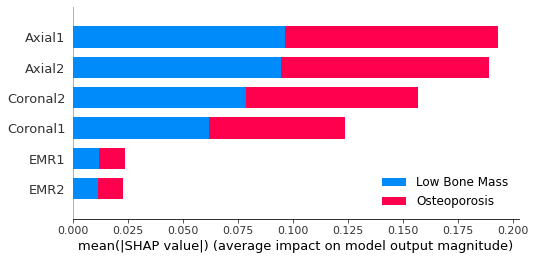

In [178]:
import shap

#dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_w_coronal_new_baseline_6k_ann_mrn.pkl', 'rb'))
labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])

names = ['Coronal1', 'Coronal2','Axial1', 'Axial2',  'EMR1', 'EMR2']
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(mat_test)
#np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()
shap.summary_plot(shap_values, mat_test, feature_names = names, class_names = ['Low Bone Mass', 'Osteoporosis'],  show=False)
plt.savefig('visualization/shap_late_fusion_w_coronal_new_baseline_6k.jpg', bbox_inches='tight')

In [187]:
##confidence interval
from random import randint, sample


dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_w_coronal_new_baseline_6k_ann_mrn.pkl', 'rb'))
y_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])
#preds = np.array([1 if probs[i,1]>=0.5 else 0 for i in range(len(preds))])


companies = ['MN', 'FL', 'AZ', 'MCHS']
c =  companies[3]
idx = np.array([i for i in range(len(df_test)) if c == df_test.facility.values[i]])

print(c)
    
target_test = y_test

target_test = target_test[idx]
preds = preds[idx]
probs = probs[idx]

avg_precision = []
avg_recall = []
avg_fscore = []
aucroc = []
   
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    


    i_y_test = target_test[i_test_idx]
    i_y_pred = preds[i_test_idx]
    i_y_prob = probs[i_test_idx,1]

    dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
    avg_precision.append(dct['macro avg']['precision'])
    avg_recall.append(dct['macro avg']['recall'])
    avg_fscore.append(dct['macro avg']['f1-score'])

    aucroc.append(roc_auc_score(i_y_test, i_y_prob))
    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))


p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_precision, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_precision, p, axis = 0)
print('Precision')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_recall, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_recall, p, axis = 0)
print('Recall')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_fscore, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_fscore, p, axis = 0)
print('F-score')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(aucroc, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(aucroc, p, axis = 0)
print('AUC-ROC')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

MCHS
Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
Precision
[84.6-93.1]
Recall
[87.3-94.7]
F-score
[85.5-93.6]
AUC-ROC
[87.5-96.3]


In [66]:
print('FEMALE')
print(classification_report(labels_test[female_idx], preds2[female_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[female_idx], probs[female_idx, 1]))
cm = confusion_matrix(labels_test[female_idx], preds2[female_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)
print('MALE')
print(classification_report(labels_test[male_idx], preds2[male_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[male_idx], probs[male_idx, 1]))
cm = confusion_matrix(labels_test[male_idx], preds2[male_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)

FEMALE
              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       359
         1.0       0.80      0.82      0.81       426

    accuracy                           0.79       785
   macro avg       0.79      0.79      0.79       785
weighted avg       0.79      0.79      0.79       785

AUC-ROC:	 0.8545124040435744
Confusion Matrix:
 [[272  87]
 [ 77 349]]
MALE
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       311
         1.0       0.60      0.65      0.62       109

    accuracy                           0.80       420
   macro avg       0.74      0.75      0.74       420
weighted avg       0.80      0.80      0.80       420

AUC-ROC:	 0.8554824626095165
Confusion Matrix:
 [[263  48]
 [ 38  71]]


In [67]:
companies = ['ge', 'siemens', 'toshiba']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c in df_test.Manufacturer.values[i].lower()])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

GE
              precision    recall  f1-score   support

         0.0       0.80      0.89      0.84        85
         1.0       0.85      0.73      0.78        70

    accuracy                           0.82       155
   macro avg       0.82      0.81      0.81       155
weighted avg       0.82      0.82      0.82       155

AUC-ROC:	 0.9117647058823529
Confusion Matrix:
 [[76  9]
 [19 51]]
SIEMENS
              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80       561
         1.0       0.74      0.79      0.76       442

    accuracy                           0.78      1003
   macro avg       0.78      0.78      0.78      1003
weighted avg       0.79      0.78      0.78      1003

AUC-ROC:	 0.8616098434437534
Confusion Matrix:
 [[437 124]
 [ 93 349]]
TOSHIBA
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        24
         1.0       0.91      0.87      0.89        23

    accuracy             

In [68]:
dia = [0, 250, 350, 1000]
for i in range(1, len(dia)):
    lower = dia[i-1]
    upper = dia[i]
    print(str(lower)+'-'+str(upper))
    idx = np.array([i for i in range(len(df_test)) if (df_test.CrossSectionSpacing.values[i]>=lower and df_test.CrossSectionSpacing.values[i]<upper)])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

0-250
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.65        56
         1.0       0.83      0.86      0.85       123

    accuracy                           0.79       179
   macro avg       0.75      0.74      0.75       179
weighted avg       0.78      0.79      0.79       179

AUC-ROC:	 0.8244047619047618
Confusion Matrix:
 [[ 35  21]
 [ 17 106]]
250-350
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       472
         1.0       0.76      0.78      0.77       380

    accuracy                           0.79       852
   macro avg       0.79      0.79      0.79       852
weighted avg       0.79      0.79      0.79       852

AUC-ROC:	 0.8687946030330063
Confusion Matrix:
 [[376  96]
 [ 84 296]]
350-1000
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89       142
         1.0       0.50      0.56      0.53        32

    accuracy     

In [35]:
df_test.facility.values[i].lower()

'fl'

In [183]:
companies = ['MN', 'FL', 'AZ', 'MCHS']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c == df_test.facility.values[i]])
    #print(idx)
    print(classification_report(labels_test[idx], preds[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

MN
              precision    recall  f1-score   support

         0.0       0.83      0.74      0.78       234
         1.0       0.75      0.84      0.79       221

    accuracy                           0.78       455
   macro avg       0.79      0.79      0.78       455
weighted avg       0.79      0.78      0.78       455

AUC-ROC:	 0.8713887922032719
Confusion Matrix:
 [[172  62]
 [ 36 185]]
FL
              precision    recall  f1-score   support

         0.0       0.86      0.77      0.81       199
         1.0       0.65      0.78      0.71       111

    accuracy                           0.77       310
   macro avg       0.76      0.78      0.76       310
weighted avg       0.79      0.77      0.78       310

AUC-ROC:	 0.838697994476889
Confusion Matrix:
 [[153  46]
 [ 24  87]]
AZ
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       179
         1.0       0.81      0.75      0.78       170

    accuracy                    

### Late Fusion - Axial, Coronal, Gender, Age, Daimeter

In [9]:
def labeling(x):
    if x<=-1:
        return 1
    else:
        return 0
def age_mapping(x):
    if type(x) is str:
        if len(x)==4:
            return x[1]
        else:
            return x[0]
    else:
        return 'UNKNOWN'

#136.1302176492294, 462.9853871884079
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing.csv')
#df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235_w_view_locations_w_L3_slice_patient_manufacturer_info.csv') #use this so that no L3 slice detected can be filtered out
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print(len(df))

df['Label'] = df['TOTAL_SPINE_TSCORE'].apply(labeling)
print(df['Label'].value_counts())

df['PatientAge_mapped'] = df.PatientAge.apply(age_mapping)
print(df['PatientAge_mapped'].value_counts())

a = df['CrossSectionSpacing'].values
df['CrossSectionSpacing_norm'] = (a-np.min(a))/(np.max(a)-np.min(a))
df['CrossSectionSpacing_binned'] = pd.cut(df['CrossSectionSpacing'].values, 10)

dct = pkl.load(open('../bucket/Amara/Osteo/CT_acc_split_basic1235678.pkl', 'rb'))
acc_train = dct['CT_acc_train']
acc_test = dct['CT_acc_test']
acc_val = dct['CT_acc_val']



df_train = df.loc[df.CT_acc.isin(acc_train)]
df_test = df.loc[df.CT_acc.isin(acc_test)]
df_val = df.loc[df.CT_acc.isin(acc_val)]

print(df_train['Label'].value_counts())
print(df_test['Label'].value_counts())
print(df_val['Label'].value_counts())

labels_train = df_train.Label.values
labels_test = df_test.Label.values
labels_val = df_val.Label.values

female_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]=='F'])
male_idx = np.array([i for i in range(len(df_test)) if df_test.PatientSex.values[i]=='M'])

6083
6083
0    3108
1    2975
Name: Label, dtype: int64
6          2385
7          1482
5          1384
8           555
UNKNOWN     222
9            55
Name: PatientAge_mapped, dtype: int64
0    1686
1    1570
Name: Label, dtype: int64
0    491
1    472
Name: Label, dtype: int64
0    204
1    196
Name: Label, dtype: int64


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (18,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
## Training
## Training
dct_axial = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-26/train_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-27/train_predictions.pkl', 'rb'))
dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])
mat = np.array([(dct_axial['probs']), 1-(dct_axial['probs']), (dct_coronal['probs']), 1-(dct_coronal['probs'])]).transpose()
labels_train = dct_axial['labels']



#Test
dct_axial = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-26/test_predictions.pkl', 'rb'))
dct_coronal = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-27/test_predictions.pkl', 'rb'))
dct_axial['probs'] = np.array(dct_axial['probs'])
dct_coronal['probs'] = np.array(dct_coronal['probs'])
mat_test = np.array([dct_axial['probs'], 1-(dct_axial['probs']), (dct_coronal['probs']), 1-(dct_coronal['probs'])]).transpose()

labels_test = dct_axial['labels']


print(mat.shape, len(labels_train), mat_test.shape, len(labels_test))


discrete_cols = ['PatientAge_mapped', 'PatientSex', 'CrossSectionSpacing_binned']
cont_cols = [ 'CrossSectionSpacing_norm']
npd_discrete = df_train[discrete_cols].copy().to_numpy()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(npd_discrete)

npd_cont = df_train[cont_cols].copy().to_numpy().reshape(-1,1)
mat = np.concatenate((enc.transform(npd_discrete).todense(), mat), axis=1) #, npd_cont
#mat = enc.transform(npd_discrete).todense()

npd_discrete = df_test[discrete_cols].copy().to_numpy()

npd_cont = df_test[cont_cols].copy().to_numpy().reshape(-1,1)
mat_test = np.concatenate((enc.transform(npd_discrete).todense(), mat_test), axis=1) # , npd_cont

mat = mat[:, [i for i in range(22) if i!= 5]]
mat_test = mat_test[:, [i for i in range(22) if i!= 5]]
mat.shape, mat_test.shape

(3256, 4) 3256 (963, 4) 963


((3256, 21), (963, 21))

In [162]:
from sklearn.svm import SVC

clf = RandomForestClassifier(random_state=0, max_depth  = 15)#xgboost.XGBClassifier(random_state=0)# max_depth 6#
clf.fit(mat, [True if l==1 else False for l in labels_train])#labels_train)
#print(np.min(mat_norm, axis=0), np.max(mat_norm, axis=0), np.mean(mat_norm, axis=0))
preds = clf.predict(mat_test)
probs = clf.predict_proba(mat_test)
#print(np.min(mat_test_norm, axis=0), np.max(mat_test_norm, axis=0), np.mean(mat_test_norm, axis=0))
preds2 = np.array([1 if probs[i,1]>=0.5 else 0 for i in range(len(preds))]) #0.35

print(classification_report(labels_test, preds2))
print('AUC-ROC:\t', roc_auc_score(labels_test, probs[:,1]))
cm = confusion_matrix(labels_test, preds2, labels = [0, 1])
print('Confusion Matrix:\n', cm)
dct = {}
dct['labels'] = labels_test
dct['preds'] = preds
dct['probs'] = probs

labels_test = np.array(dct['labels'])
preds = np.array(dct['preds'])
probs = np.array(dct['probs'])

#pkl.dump(dct, open('../bucket/Amara/Osteo/Results/late_fusion_resized_coronal_w_demo_6k.pkl', 'wb'))
# fg = plot_confusion_matrix(cm , normalize = False, target_names= ['No Osteoporosis', 'Osteoproorses'] )
# fg.savefig('../bucket/Amara/Osteo/Results/late_fusion.jpg', bbox_inches='tight')#

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       491
         1.0       0.82      0.79      0.80       472

    accuracy                           0.81       963
   macro avg       0.81      0.81      0.81       963
weighted avg       0.81      0.81      0.81       963

AUC-ROC:	 0.8930688839794263
Confusion Matrix:
 [[410  81]
 [101 371]]


([<matplotlib.axis.XTick at 0x7fdf8f471f50>,
 [Text(0, 0, 'Age:<60years'),
  Text(1, 0, 'Age:60-70years'),
  Text(2, 0, 'Age:70-80years'),
  Text(3, 0, 'Age:80-90years'),
  Text(4, 0, 'Age:>90years'),
  Text(5, 0, 'Female'),
  Text(6, 0, 'Male'),
  Text(7, 0, 'Eff. Diameter1'),
  Text(8, 0, 'Eff. Diameter2'),
  Text(9, 0, 'Eff. Diameter3'),
  Text(10, 0, 'Eff. Diameter4'),
  Text(11, 0, 'Eff. Diameter5'),
  Text(12, 0, 'Eff. Diameter6'),
  Text(13, 0, 'Eff. Diameter7'),
  Text(14, 0, 'Eff. Diameter8'),
  Text(15, 0, 'Eff. Diameter9'),
  Text(16, 0, 'Eff. Diameter10'),
  Text(17, 0, 'Axial1'),
  Text(18, 0, 'Axial2'),
  Text(19, 0, 'Coronal1'),
  Text(20, 0, 'Coronal2')])

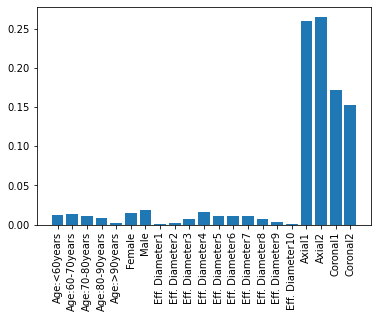

In [129]:
y = clf.feature_importances_#list(clf.feature_importances_[:5]) + list(clf.feature_importances_[6:])
names = ['Age:<60years', 'Age:60-70years', 'Age:70-80years', 'Age:80-90years', 'Age:>90years', 'Female', 'Male', 'Eff. Diameter1', 'Eff. Diameter2', 'Eff. Diameter3', 'Eff. Diameter4', 
        'Eff. Diameter5', 'Eff. Diameter6', 'Eff. Diameter7', 'Eff. Diameter8', 'Eff. Diameter9', 'Eff. Diameter10', 'Axial1', 'Axial2', 'Coronal1', 'Coronal2']
plt.bar(np.arange(mat.shape[1]), y)
plt.xticks(np.arange(mat.shape[1]), labels=names, rotation=90)
#plt.savefig('../bucket/Amara/Osteo/fetaure_importance_late_fusion_w_demo_6k.jpg')

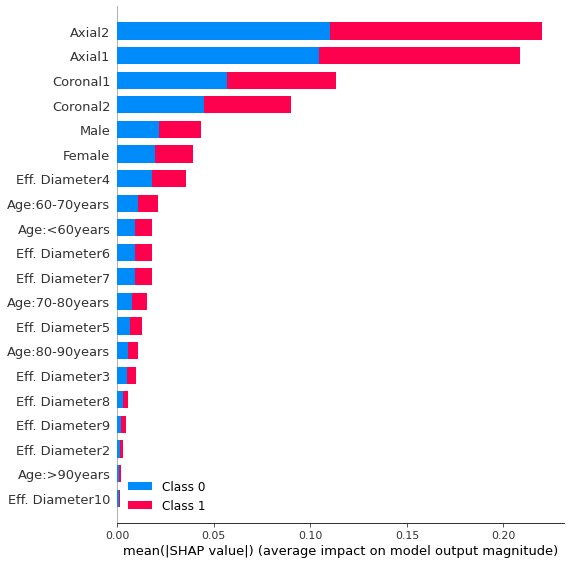

In [161]:
import shap
#pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(mat_test)
#np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()
shap.summary_plot(shap_values, mat_test, feature_names = names, show=False)
plt.savefig('visualization/shap_late_fusion_6k.jpg', bbox_inches='tight')

In [156]:
explainer = shap.TreeExplainer(clf, feature_perturbation='interventional')
# Compute the estimated Shapley values for the test sample's observations
shap_values = explainer.shap_values(mat_test[:100,:])

In [157]:
shap.plots.beeswarm(shap_values, mat_test[:100,:])#shap.summary_plot(shap_values, mat_test[:100,:])

UnboundLocalError: local variable 'values' referenced before assignment

In [159]:
import copy
explainer = shap.Explainer(clf)
shap_values1 = explainer(mat_test[:100,:])
shap_values2 = copy.deepcopy(shap_values1)
shap_values2.values = shap_values2.values[:,:,1]
shap_values2.base_values = shap_values2.base_values[:,1]

shap.plots.beeswarm(shap_values1)

ValueError: The beeswarm plot does not support plotting explanations with instances that have more than one dimension!

In [147]:
# train XGBoost model
import xgboost
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context
X,y = shap.datasets.adult()
print(X.shape)
model = RandomForestClassifier(random_state=0).fit(X.iloc[0:100], y[:100])#xgboost.XGBClassifier().fit(X.iloc[0:100], y[:100])#

# compute SHAP values
explainer = shap.TreeExplainer(model, X.iloc[0:100])
shap_values = explainer(X.iloc[0:100])

# import copy
# explainer = shap.Explainer(clf)
# shap_values1 = explainer(mat_test[:100,:])
# shap_values2 = copy.deepcopy(shap_values1)
# shap_values2.values = shap_values2.values[:,:,1]
# shap_values2.base_values = shap_values2.base_values[:,1]



#shap.plots.beeswarm(shap_values2)

#shap.plots.beeswarm(shap_values)

(32561, 12)


100%|===================| 64918/65122 [03:53<00:00]        

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

[22:33:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


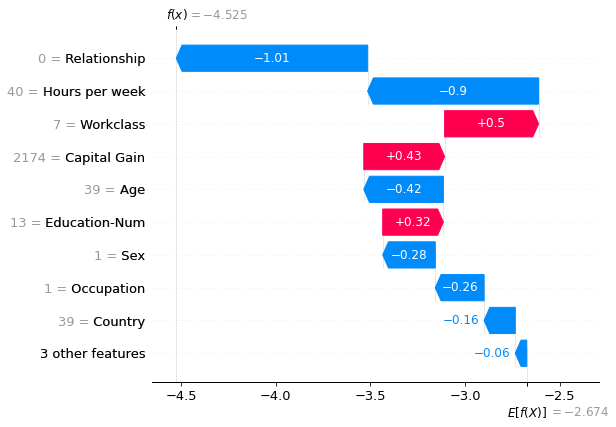

In [149]:
import xgboost
import shap

# train XGBoost model
X,y = shap.datasets.adult()
model = xgboost.XGBClassifier().fit(X.iloc[0:100], y[:100])

# compute SHAP values
explainer = shap.Explainer(model,X.iloc[0:100])
shap_values = explainer(X.iloc[0:100])
shap.plots.waterfall(shap_values[0])

In [57]:
X.iloc[0:100]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,29.0,2,10.0,4,6,0,4,1,0.0,0.0,50.0,39
96,48.0,6,16.0,2,10,4,4,1,0.0,1902.0,60.0,39
97,37.0,4,10.0,2,12,4,4,1,0.0,0.0,48.0,39
98,48.0,4,12.0,0,4,1,4,0,0.0,0.0,40.0,9


In [188]:
dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_resized_coronal_w_demo_6k.pkl', 'rb'))
y_test = np.array(dct['labels'])
probs = np.array(dct['probs'])
preds = np.array([1 if probs[i,1]>=0.5 else 0 for i in range(len(probs))])

print('FEMALE')
print(classification_report(labels_test[female_idx], preds2[female_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[female_idx], probs[female_idx,1]))
cm = confusion_matrix(labels_test[female_idx], preds2[female_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)
# fg = plot_confusion_matrix(cm , normalize = False, target_names= ['No Osteoporosis', 'Osteoproorses'] )
# fg.savefig('../bucket/Amara/Osteo/Results/CM_Late_Fusion_female.jpg', bbox_inches='tight')
print('MALE')
print(classification_report(labels_test[male_idx], preds2[male_idx]))
print('AUC-ROC:\t', roc_auc_score(labels_test[male_idx], probs[male_idx,1]))
cm = confusion_matrix(labels_test[male_idx], preds2[male_idx], labels = [0, 1])
print('Confusion Matrix:\n', cm)

FEMALE
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79       277
         1.0       0.83      0.87      0.85       366

    accuracy                           0.83       643
   macro avg       0.82      0.82      0.82       643
weighted avg       0.83      0.83      0.83       643

AUC-ROC:	 0.8951884949991122
Confusion Matrix:
 [[214  63]
 [ 49 317]]
MALE
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       214
         1.0       0.68      0.63      0.66       106

    accuracy                           0.78       320
   macro avg       0.75      0.74      0.75       320
weighted avg       0.78      0.78      0.78       320

AUC-ROC:	 0.8602980074061012
Confusion Matrix:
 [[183  31]
 [ 39  67]]


In [189]:
companies = ['ge', 'siemens', 'toshiba']
for c in companies:
    print(c.upper())
    idx = np.array([i for i in range(len(df_test)) if c in df_test.Manufacturer.values[i].lower()])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

GE
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84        72
         1.0       0.77      0.74      0.76        50

    accuracy                           0.80       122
   macro avg       0.80      0.79      0.80       122
weighted avg       0.80      0.80      0.80       122

AUC-ROC:	 0.8658333333333333
Confusion Matrix:
 [[61 11]
 [13 37]]
SIEMENS
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       393
         1.0       0.82      0.83      0.82       405

    accuracy                           0.82       798
   macro avg       0.82      0.82      0.82       798
weighted avg       0.82      0.82      0.82       798

AUC-ROC:	 0.900021989759055
Confusion Matrix:
 [[317  76]
 [ 70 335]]
TOSHIBA
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76        26
         1.0       0.61      0.69      0.65        16

    accuracy              

In [190]:
dia = [0, 250, 350, 1000]
for i in range(1, len(dia)):
    lower = dia[i-1]
    upper = dia[i]
    print(str(lower)+'-'+str(upper))
    idx = np.array([i for i in range(len(df_test)) if (df_test.CrossSectionSpacing.values[i]>=lower and df_test.CrossSectionSpacing.values[i]<upper)])
    #print(idx)
    print(classification_report(labels_test[idx], preds2[idx]))
    print('AUC-ROC:\t', roc_auc_score(labels_test[idx], probs[idx,1]))
    cm = confusion_matrix(labels_test[idx], preds2[idx], labels = [0, 1])
    print('Confusion Matrix:\n', cm)

0-250
              precision    recall  f1-score   support

         0.0       0.74      0.62      0.67        47
         1.0       0.84      0.90      0.87       103

    accuracy                           0.81       150
   macro avg       0.79      0.76      0.77       150
weighted avg       0.81      0.81      0.81       150

AUC-ROC:	 0.8746126833298904
Confusion Matrix:
 [[29 18]
 [10 93]]
250-350
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.82       328
         1.0       0.82      0.81      0.81       327

    accuracy                           0.82       655
   macro avg       0.82      0.82      0.82       655
weighted avg       0.82      0.82      0.82       655

AUC-ROC:	 0.8985697769821734
Confusion Matrix:
 [[269  59]
 [ 62 265]]
350-1000
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.86       116
         1.0       0.60      0.62      0.61        42

    accuracy         

In [191]:
##confidence interval
from random import randint, sample


dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_resized_coronal_w_demo_6k.pkl', 'rb'))
y_test = np.array(dct['labels'])
probs = np.array(dct['probs'])
preds = np.array([1 if probs[i,1]>=0.35 else 0 for i in range(len(probs))])



target_test = y_test

avg_precision = []
avg_recall = []
avg_fscore = []
aucroc = []
   
test_set_size = len(target_test)
for i in range(1000):
    # randomly pick size of the test set
    i_size = randint(round(0.5*test_set_size), test_set_size)
    
    i_test_idx = sample([ii for ii in range(test_set_size)], i_size)
    i_test_idx.sort()
    
    


    i_y_test = target_test[i_test_idx]
    i_y_pred = preds[i_test_idx]
    i_y_prob = probs[i_test_idx,1]

    dct = classification_report(i_y_test, i_y_pred, output_dict=True, zero_division=0)
    avg_precision.append(dct['macro avg']['precision'])
    avg_recall.append(dct['macro avg']['recall'])
    avg_fscore.append(dct['macro avg']['f1-score'])

    aucroc.append(roc_auc_score(i_y_test, i_y_prob))
    if i%100==0:
        print('Iteration:\t'+str(i))
        
# confidence intervals
alpha = 0.95
print('%.1f confidence interval ' % (alpha*100))


p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_precision, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_precision, p, axis = 0)
print('Precision')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_recall, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_recall, p, axis = 0)
print('Recall')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(avg_fscore, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(avg_fscore, p, axis = 0)
print('F-score')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

p = ((1.0-alpha)/2.0) * 100
lower = np.percentile(aucroc, p, axis= 0)
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = np.percentile(aucroc, p, axis = 0)
print('AUC-ROC')
print('['+str(np.round(lower*100, decimals=1))+'-'+str(np.round(upper*100, decimals=1))+']')

Iteration:	0
Iteration:	100
Iteration:	200
Iteration:	300
Iteration:	400
Iteration:	500
Iteration:	600
Iteration:	700
Iteration:	800
Iteration:	900
95.0 confidence interval 
Precision
[78.4-81.8]
Recall
[77.2-80.6]
F-score
[76.6-80.3]
AUC-ROC
[87.8-90.5]


#### GradCAM

In [207]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [142]:
import pandas as pd
import pickle as pkl
import numpy as np
from tqdm import tqdm
import os
import sys
from os import path
import pickle as pkl
import matplotlib.pyplot as plt
import datetime
import utils
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, pairwise_distances, classification_report
from sklearn.decomposition import PCA

import nibabel as nib
# PyTorch libraries and modules
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py

import sys
import time

def vol_window(vol, level, window):
    maxval = level + window/2
    minval = level - window/2
    vol[vol<minval] = minval
    vol[vol>maxval] = maxval
    return vol

class CTDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def image_loader(self, image_name):
        trans = transforms.Compose([
                                                                    transforms.Scale((256, 256)),
                                                                    transforms.CenterCrop(256),
                                                                    transforms.ToTensor()])#,  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


        a = np.load(image_name)
        a = a.astype(float)
        a = vol_window(a, 500, 1500)
        a = (a-np.min(a))/(np.max(a)-np.min(a))
        a = 255.0*a
        image = Image.fromarray(np.uint8(a)).convert('RGB')
        
        image = trans(image).float()
        image = Variable(image, requires_grad=True)
        #image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        return image  
    
    def __getitem__(self, index):
        header = '../bucket/Amara/Osteo/Coronal_Slices/'
        y = self.df.at[self.df.index[index], 'TOTAL_SPINE_TSCORE']
        if y<=-1:
            y = 1
        else:
            y = 0
        #print(self.df.at[self.df.index[index], 'NIFTI location-Transverse'])
        #print(self.df.at[self.df.index[index], 'NIFTI location-Transverse'][3:])
        CT_acc = self.df.at[self.df.index[index], 'CT_acc']
        slice_number = int(self.df.at[self.df.index[index], 'coronal_slice'])
        
        image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'#'../'+self.df.at[self.df.index[index], 'NIFTI location-Transverse'].strip('../')
        
        x = self.image_loader(image_name)
        y = torch.tensor([y], dtype=torch.float)
        return x, y #y normalized

batch_size = 1
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing_w_orientation.csv')
print('data frame read', len(df))
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print('data frame after filtering:', len(df))


dct = pkl.load(open('../bucket/Amara/Osteo/mrn_split_basic1235678.pkl', 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[df.mrn.isin(mrn_train)]
df_test = df.loc[df.mrn.isin(mrn_test)]
df_val = df.loc[df.mrn.isin(mrn_val)]


print('Train', np.unique([1 if t<=-1 else 0 for t in df_train['TOTAL_SPINE_TSCORE'].values], return_counts=True))
print('Test', np.unique([1 if t<=-1 else 0 for t in df_test['TOTAL_SPINE_TSCORE'].values], return_counts=True))
print('Val', np.unique([1 if t<=-1 else 0 for t in df_val['TOTAL_SPINE_TSCORE'].values], return_counts=True))


datagen_train = CTDataset(df =  df_train.copy()) 
datagen_val = CTDataset(df = df_val.copy()) 
datagen_test = CTDataset(df = df_test.copy()) 

train_loader = DataLoader(dataset=datagen_train, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(dataset=datagen_val,  shuffle=False, batch_size=batch_size)
test_loader = DataLoader(dataset=datagen_test,  shuffle=False, batch_size=batch_size)

# model = models.densenet121(pretrained=True)
# model.classifier = nn.Sequential(nn.Linear(1024, 1))#, nn.Sigmoid())
# best_path = '../bucket/Amara/Osteo/Class/train/train-26/best.pth.tar' ##axial-6k
# model = utils.load_model_checkpoint(best_path, model) 
# print('modal loaded')
# sys.stdout.flush()


model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(nn.Linear(1024, 1))#, nn.Sigmoid())
best_path = '../bucket/Amara/Osteo/Class/train/train-32/best.pth.tar' # coronal6k
model = utils.load_model_checkpoint(best_path, model) 
print('modal loaded')
sys.stdout.flush()
for j, data in enumerate(test_loader):
    print(data[0].shape)
    break

Columns (29,33) have mixed types.Specify dtype option on import or set low_memory=False.


data frame read 6083
6083
data frame after filtering: 6083
Train (array([0, 1]), array([2209, 2199]))
Test (array([0, 1]), array([670, 535]))
Val (array([0, 1]), array([229, 241]))
modal loaded
torch.Size([1, 3, 256, 256])


The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [144]:
dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb'))
TP = []
FP = []
FN = []
for i in range(len(dct['labels'])):
    if dct['labels'][i]==1 and dct['preds'][i]==1:
        TP.append(i)
    elif dct['labels'][i]==1 and dct['preds'][i]==0:
        FN.append(i)
    elif dct['labels'][i]==0 and dct['preds'][i]==1:
        FP.append(i)
print('TP:\t', TP[-50:])
print('FP:\t', FP[-25:])
print('FN:\t', FN[-25:])

TP:	 [1090, 1091, 1094, 1095, 1097, 1098, 1099, 1107, 1118, 1119, 1121, 1122, 1123, 1125, 1126, 1130, 1133, 1137, 1139, 1140, 1143, 1144, 1146, 1151, 1152, 1157, 1161, 1162, 1163, 1164, 1165, 1167, 1168, 1169, 1171, 1175, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1189, 1190, 1191, 1192, 1194, 1197]
FP:	 [1062, 1067, 1069, 1073, 1078, 1079, 1080, 1085, 1092, 1101, 1103, 1111, 1112, 1114, 1115, 1117, 1135, 1136, 1145, 1150, 1153, 1159, 1195, 1200, 1203]
FN:	 [870, 877, 894, 896, 931, 933, 934, 938, 940, 954, 958, 974, 975, 982, 994, 1028, 1052, 1077, 1093, 1096, 1109, 1110, 1132, 1199, 1202]


In [160]:
TP = np.random.choice(TP, size = 50, replace=False)
FP = np.random.choice(FP, size = 50, replace=False)
FN = np.random.choice(FN, size = 50, replace=False)
print(TP, FP, FN)

[ 665  900  971  340  111  445  861  127  748  508  833  464  584 1143
  469  170  803  838  805  210  318  917  788  869  395  782  220  770
  252  897 1047  558 1087  168  811  164 1038  696 1082  690  542  320
  507 1146  237  376  280  529  789  144] [1159  330  423  745  473  858  248  630  462  418   39 1112 1059 1200
  924  290  378  192 1036  398   87  583  675  338  884  450  303  785
  612  494  822  496  125  438  772  513  511  266  681   57 1010  854
  827  736  562 1203  260  533  505  718] [ 933  336  205  931  431  239  504  707 1028  864  817  894  799  454
 1052  140   71 1077  374  480  821  219  531  391  590  589  712  208
  315  698 1093  704  601  381  102   36  793  726  199  739  194  572
  264  954   24  610  305  877  178  331]


In [171]:
def image_loader(image_name):
        trans = transforms.Compose([
                                                                    transforms.Scale((256, 256)),
                                                                    transforms.CenterCrop(256),
                                                                    transforms.ToTensor()])#,  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


        a = np.load(image_name)
        a = a.astype(float)
        a = vol_window(a, 500, 1500)
        a = (a-np.min(a))/(np.max(a)-np.min(a))
        a = 255.0*a
        image = Image.fromarray(np.uint8(a)).convert('RGB')
        
        image = trans(image).float()
        image = Variable(image, requires_grad=True)
        #image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        return image  


k = 0
for index in FN[:25]:
    target_layers = [model.features.denseblock4.denselayer4]

    header = '../bucket/Amara/Osteo/Coronal_Slices_detected/'
    CT_acc = df_test.at[df_test.index[index], 'CT_acc']
    print(index, df_test.at[df_test.index[index], 'coronal_slice_detected'], df_test.at[df_test.index[index], 'coronal_slice'])
    slice_number = int(df_test.at[df_test.index[index], 'coronal_slice_detected'])
    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'
    

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)


    data = image_loader(image_name)
    data = data.unsqueeze(axis = 0)
    input_tensor = data# Create an input tensor image for your model..
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])
    grayscale_cam = grayscale_cam[0, :]

    rgb_img = input_tensor.detach().numpy().squeeze()

    rgb_img = np.moveaxis(rgb_img, 0, -1)
    #rgb_img.numpy().moveaxis()

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, colormap=5)
    plt.figure()
    plt.imshow(visualization)
    k+=1
    print(k)
    plt.savefig('visualization/coronal_detected/FN/coronal_FP_block4_image'+str(index)+'.jpg')


In [208]:
def vol_window(vol, level, window):
    maxval = level + window/2
    minval = level - window/2
    vol[vol<minval] = minval
    vol[vol>maxval] = maxval
    return vol

class CTDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def image_loader(self, image_name):
        trans = transforms.Compose([
                                                                    transforms.Scale(256),
                                                                    transforms.CenterCrop(256),
                                                                    transforms.ToTensor()])#,  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


        a = np.load(image_name)
        a = a.astype(float)
        a = vol_window(a, 500, 1500)
        a = (a-np.min(a))/(np.max(a)-np.min(a))
        a = 255.0*a
        image = Image.fromarray(np.uint8(a)).convert('RGB')
        
        image = trans(image).float()
        image = Variable(image, requires_grad=True)
        #image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        return image  
    
    def __getitem__(self, index):
        header = '../bucket/Amara/Osteo/L3_Slices/'
        y = self.df.at[self.df.index[index], 'TOTAL_SPINE_TSCORE']
        if y<=-1:
            y = 1
        else:
            y = 0
        #print(self.df.at[self.df.index[index], 'NIFTI location-Transverse'])
        #print(self.df.at[self.df.index[index], 'NIFTI location-Transverse'][3:])
        CT_acc = self.df.at[self.df.index[index], 'CT_acc']
        slice_number = int(self.df.at[self.df.index[index], 'L3_slice'])
        prob = self.df.at[self.df.index[index], 'L3_slice_prob']
        #print(CT_acc, slice_number, np.round(prob, decimals=2) )
        image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'#'../'+self.df.at[self.df.index[index], 'NIFTI location-Transverse'].strip('../')
        
        x = self.image_loader(image_name)
        y = torch.tensor([y], dtype=torch.float)
        return x, y #y normalized
    
    
batch_size = 1
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing.csv')#('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235_w_view_locations_w_coronal_slice4.csv')
#df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped12_w_view_locations.xlsx')
print('data frame read', len(df))
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print('data frame after filtering:', len(df))

dct = pkl.load(open('../bucket/Amara/Osteo/mrn_split_basic1235678.pkl', 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[df.mrn.isin(mrn_train)]
df_test = df.loc[df.mrn.isin(mrn_test)]
df_val = df.loc[df.mrn.isin(mrn_val)]

print('Train', np.unique([1 if t<=-1 else 0 for t in df_train['TOTAL_SPINE_TSCORE'].values], return_counts=True))
print('Test', np.unique([1 if t<=-1 else 0 for t in df_test['TOTAL_SPINE_TSCORE'].values], return_counts=True))
print('Val', np.unique([1 if t<=-1 else 0 for t in df_val['TOTAL_SPINE_TSCORE'].values], return_counts=True))


datagen_train = CTDataset(df =  df_train.copy()) 
datagen_val = CTDataset(df = df_val.copy()) 
datagen_test = CTDataset(df = df_test.copy()) 

train_loader = DataLoader(dataset=datagen_train, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(dataset=datagen_val,  shuffle=False, batch_size=batch_size)
test_loader = DataLoader(dataset=datagen_test,  shuffle=False, batch_size=batch_size)

model = models.densenet121(pretrained=True)
model.classifier = nn.Sequential(nn.Linear(1024, 1))#, nn.Sigmoid())
best_path = '../bucket/Amara/Osteo/Class/train/train-30/best.pth.tar'
model = utils.load_model_checkpoint(best_path, model) 
print('modal loaded')
sys.stdout.flush()

Columns (18,22) have mixed types.Specify dtype option on import or set low_memory=False.


data frame read 6083
6083
data frame after filtering: 6083
Train (array([0, 1]), array([2209, 2199]))
Test (array([0, 1]), array([670, 535]))
Val (array([0, 1]), array([229, 241]))
modal loaded


In [209]:
dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb'))
TP = []
FP = []
FN = []
for i in range(len(dct['labels'])):
    if dct['labels'][i]==1 and dct['preds'][i]==1:
        TP.append(i)
    elif dct['labels'][i]==1 and dct['preds'][i]==0:
        FN.append(i)
    elif dct['labels'][i]==0 and dct['preds'][i]==1:
        FP.append(i)
print('TP:\t', TP[:50])
print('FP:\t', FP[:25])
print('FN:\t', FN[:25])

TP:	 [50, 64, 84, 94, 113, 132, 135, 142, 148, 150, 153, 164, 179, 201, 258, 259, 274, 278, 298, 301, 309, 321, 324, 325, 368, 374, 397, 406, 410, 414, 421, 422, 448, 467, 481, 483, 507, 528, 541, 563, 565, 568, 570, 574, 599, 603, 609, 623, 649, 663]
FP:	 [478, 583, 636, 867, 928, 1079, 1092]
FN:	 [1, 5, 6, 7, 9, 10, 11, 14, 19, 24, 26, 27, 33, 36, 42, 43, 46, 47, 48, 49, 52, 55, 58, 59, 61]


torch.Size([1, 3, 256, 256])
50
torch.Size([1, 3, 256, 256])
64
torch.Size([1, 3, 256, 256])
84
torch.Size([1, 3, 256, 256])
94
torch.Size([1, 3, 256, 256])
113


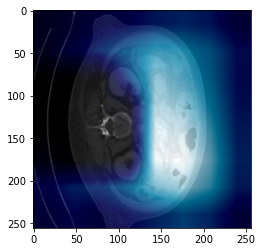

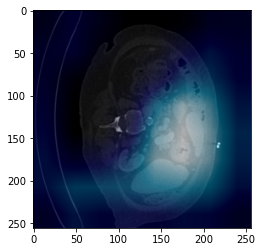

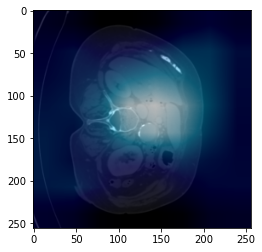

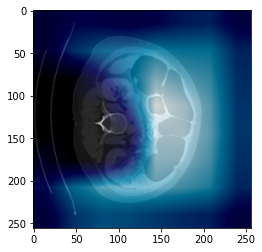

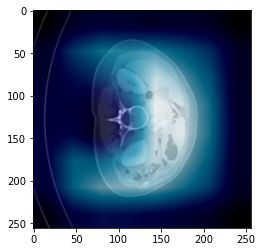

In [211]:
def image_loader(image_name):
        trans = transforms.Compose([
                                                                    transforms.Scale((256)),
                                                                    transforms.CenterCrop(256),
                                                                    transforms.ToTensor()])#,  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


        a = np.load(image_name)
        a = a.astype(float)
        a = vol_window(a, 500, 1500)
        a = (a-np.min(a))/(np.max(a)-np.min(a))
        a = 255.0*a
        image = Image.fromarray(np.uint8(a)).convert('RGB')
        
        image = trans(image).float()
        image = Variable(image, requires_grad=True)
        #image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
        return image  

#index = 599
for index in TP[:5]:
    target_layers = [model.features.denseblock4.denselayer4]

    header = '../bucket/Amara/Osteo/L3_Slices/'
    CT_acc = df_test.at[df_test.index[index], 'CT_acc']
    slice_number = int(df_test.at[df_test.index[index], 'L3_slice'])
    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'


    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)


    data = image_loader(image_name)
    data = data.unsqueeze(axis = 0)
    print(data.shape)
    input_tensor = data# Create an input tensor image for your model..
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(0)])
    grayscale_cam = grayscale_cam[0, :]


    CT_acc = df_test.at[df_test.index[index], 'CT_acc']
    slice_number = int(df_test.at[df_test.index[index], 'L3_slice'])
    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'

    rgb_img = input_tensor.detach().numpy().squeeze()
    rgb_img = np.moveaxis(rgb_img, 0, -1)
    #rgb_img.numpy().moveaxis()

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, colormap=5)
    print(index)
    plt.figure()
    plt.imshow(visualization)

    #plt.savefig('visualization/axial_FN_block4_image'+str(index)+'.jpg')

In [124]:
from roc_utils import *

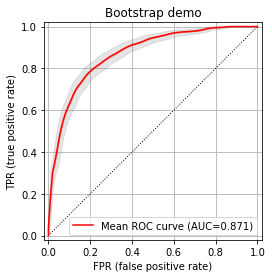

In [131]:
#dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb')) #axial
#dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb')) # coronal
#dct = pkl.load(open('../bucket/Amara/Osteo/Results/baseline_w_diameter_binned_test_6k_ann_mrn.pkl', 'rb')) # baseline
dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_w_coronal_new_baseline_6k_ann_mrn.pkl', 'rb')) #late fusion

y_test = np.array(dct['labels'])
probs = np.array(dct['probs'])

rocs = compute_roc_bootstrap(X=probs[:,1], y=y_test, pos_label=1.0,#[:,1]
                             n_bootstrap=1000,
                             random_state=42,
                             return_mean=False)

plot_mean_roc(rocs, show_ci=True, show_ti=True)
plt.title("Bootstrap demo");
plt.savefig('visualization/fusion_new_mean_roc.jpg')
plt.show()

minopt:         thr= 0.533, J= -0.289


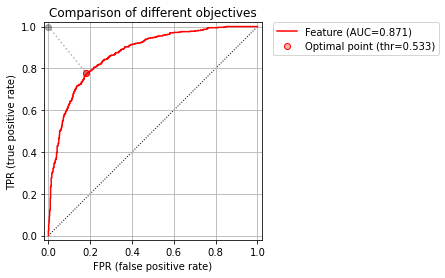

In [132]:
# Note that multiple objective functions can be computed at the same time.
#dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb')) #axial
# dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb')) # coronal
#dct = pkl.load(open('../bucket/Amara/Osteo/Results/baseline_w_diameter_binned_test_6k_ann_mrn.pkl', 'rb')) # baseline
dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_w_coronal_new_baseline_6k_ann_mrn.pkl', 'rb')) #late fusion

y_test = np.array(dct['labels'])
probs = np.array(dct['probs'])

roc = compute_roc(X=probs[:,1], y=y_test, pos_label=1.0,
                  objective=["minopt"
#                              , "minoptsym", 
#                              "youden", "cost",
#                              "concordance",
                             #"lr+", "lr-",    # Possibly buggy
                             #"dor", "chi2",   # Possibly buggy
#                              "acc", "cohen"
                            ])
for key, val in roc.opd.items():
    print("%-15s thr=% .3f, J=%7.3f" % (key+":", val.opt, val.opo) )
    
plot_roc(roc, show_opt=True)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title("Comparison of different objectives");
plt.savefig('visualization/fusion_new_roc_op.jpg', bbox_inches='tight')

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


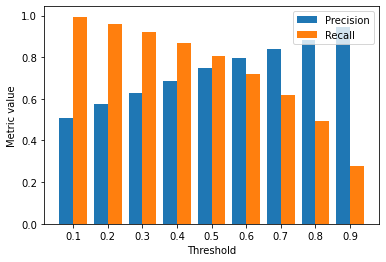

In [138]:
from sklearn.metrics import precision_score, recall_score
# Note that multiple objective functions can be computed at the same time.

#dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'rb')) #axial
# dct = pkl.load(open('../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 'rb')) # coronal
#dct = pkl.load(open('../bucket/Amara/Osteo/Results/baseline_w_diameter_binned_test_6k_ann_mrn.pkl', 'rb')) # baseline
dct = pkl.load(open('../bucket/Amara/Osteo/Results/late_fusion_w_coronal_new_baseline_6k_ann_mrn.pkl', 'rb')) #late fusion
y_test = np.array(dct['labels'])
probs = np.array(dct['probs'][:, 1])

precision = []
recall = []
th_list =  [0.1, 0.2, 0.3, .4, .5, .6, .7, .8, .9]
for th in th_list:
    preds = np.array([1 if p>th else 0 for p in probs])
    precision.append(precision_score(y_test, preds))
    recall.append(recall_score(y_test, preds))
    print(th)

X_axis = np.arange(9)
plt.bar(X_axis - 0.2, precision, 0.4, label = 'Precision')
plt.bar(X_axis + 0.2, recall, 0.4, label = 'Recall')
  
plt.xticks(X_axis, th_list)
plt.ylabel("Metric value")
plt.xlabel("Threshold")

plt.legend(loc = 'upper right')

plt.savefig('visualization/late_fusion_PR.jpg', bbox_inches='tight')


# ## save excel:

# paths = {'Axial': '../bucket/Amara/Osteo/Class/train/train-30/test_predictions.pkl', 'Coronal': '../bucket/Amara/Osteo/Class/train/train-32/test_predictions.pkl', 
#         'Baseline':'../bucket/Amara/Osteo/Results/baseline_w_diameter_binned_test_6k_ann_mrn.pkl', 'LateFusion': '../bucket/Amara/Osteo/Results/late_fusion_w_coronal_new_baseline_6k_ann_mrn.pkl'}
# th_list =  [0.1, 0.2, 0.3, .4, .5, .6, .7, .8, .9]
# df = pd.DataFrame()
# idx = 0
# for k in paths.keys():
#     dct = pkl.load(open(paths[k], 'rb'))
#     y_test = np.array(dct['labels'])
#     probs = np.array(dct['probs'])
#     print(probs.shape)
#     if len(probs.shape)>1 and probs.shape[1]>1:
#         probs = probs[:,1]
#     for th in th_list:
#         df.at[idx, 'Threshold'] = th
#         preds = np.array([1 if p>th else 0 for p in probs])
#         df.at[idx, 'Precision'] = precision_score(y_test, preds)
#         df.at[idx, 'Recall'] = recall_score(y_test, preds)
#         df.at[idx, 'Model'] = k
#         idx+=1
# df.to_csv('visualization/PR_values.csv')

In [280]:
len(probs.shape)

1

### DXA Studies Metadata Extraction

In [223]:
meta = pd.read_csv('../bucket/DXA_studies_nonifti/metadata.csv')
len(meta)

5109

In [199]:
acc = meta.AccessionNumber.unique()
for i in range(3,len(acc)):
    c = acc[i]
    temp = meta.loc[meta.AccessionNumber==c]
    print(len(temp))
    break

9


In [227]:
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped12356_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing.csv')#('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235_w_view_locations_w_coronal_slice4.csv')
def to_str(x):
    if type(x) is not str:
        return str(x)
    else:
        return x
df['dxa_acc'] = df['dxa_acc'].apply(to_str)
#df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped12_w_view_locations.xlsx')
# print('data frame read', len(df))
# print(len(df))
# df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print('data frame after filtering:', len(df))

data frame after filtering: 3979


In [228]:
len([i for i in meta.AccessionNumber.values if type(i)==str]), type(meta.AccessionNumber.values[i]), len(meta)

(5109, str, 5109)

In [229]:
good = 0
for i,j in df.iterrows():
    acc = df.at[i,'dxa_acc']
    temp = meta.loc[meta.AccessionNumber==acc]
    if len(temp)>0:
        df.at[i, 'DXA_Manufacturer'] = temp.at[temp.index[0], 'Manufacturer']
        good+=1
    if i%100==0:
        print(i, good)

0 0
100 0
200 0
300 0
400 0
500 0
600 0
700 0
800 0
900 0
1000 13
1100 28
1200 31
1300 31
1400 31
1500 32
1600 32
1700 34
1800 55
1900 61
2000 64
2100 66
2200 66
2300 66
2400 92
2500 192
2600 292
2700 392
2800 492
2900 592
3000 692
3100 792
3200 892
3300 992
3400 1092
3500 1192
3600 1292
3700 1382
3800 1405
3900 1429


In [230]:
df.to_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped12356_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing_dxa_manufacturer.csv')

In [12]:
#len(df.AccessionNumber.unique()), df.Manufacturer.value_counts(), df.ManufacturerModelName.value_counts(), df.DeviceSerialNumber.value_counts()

(2105,
 GE Healthcare    3491
 TBS               572
 HOLOGIC           541
 Lexmark           215
 Hyland             82
 Visage PR          67
 Flux Inc.          24
 PACSGEAR            4
 Name: Manufacturer, dtype: int64,
 Lunar iDXA                3165
 Horizon A (S/N301626M)     241
 Horizon A (S/N301676M)     225
 Lunar Prodigy              166
 Lunar Prodigy Advance      163
 PACSGEAR Core Server       151
 Discovery C (S/N83759)      50
 PacsSCAN                    41
 Dicom Printer 2             24
 Discovery W (S/N80194)       8
 Discovery A (S/N80344)       8
 Lunar DPX                    8
 Delphi C (S/N 70449)         7
 Discovery A (S/N85115)       2
 Name: ManufacturerModelName, dtype: int64,
 210440                                  1221
 200628                                   841
 200062                                   800
 200555                                   404
 200554                                   352
 301626M                                  241
 30167

### Random Sample from Coronal Slice

In [187]:
df.columns[-20:]

Index(['ImagePositionPatient', 'PatientPosition', 'PatientOrientation',
       '-1024_1500', '1500_2500', '2500_5000', 'Width', 'Depth',
       'coronal_slice', 'CorssSection', 'CrossSection',
       'PixelSpacing_Transverse', 'PixelSpacing_Coronal',
       'PixelSpacing_Sagittal', 'PixelSpacing_Transverse_0',
       'PixelSpacing_Transverse_1', 'WidthSpacing', 'DepathSpacing',
       'DepthSpacing', 'CrossSectionSpacing'],
      dtype='object')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


data frame read 3979
3979
data frame after filtering: 3979
2513
623
2146
3600
3739
2046
2199
2466
3628
2287
143
672
3077
3667
1380
2477
2846
2206
3122
507


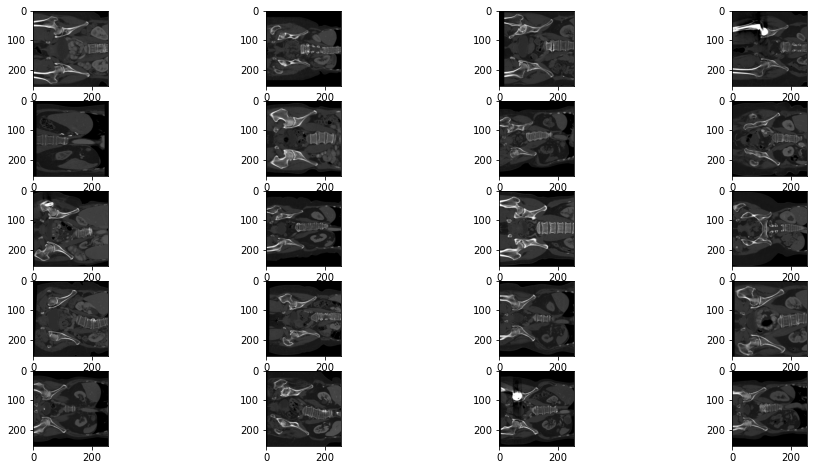

In [237]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid
from torch.autograd import Variable

df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped12356_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing.csv')#('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235_w_view_locations_w_coronal_slice4.csv')
#df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped12_w_view_locations.xlsx')
print('data frame read', len(df))
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print('data frame after filtering:', len(df))


def image_loader( image_name):
    trans = transforms.Compose([ transforms.Scale((256,256)), transforms.CenterCrop(256), transforms.ToTensor()])#,  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])


    a = np.load(image_name)
    a = a.astype(float)
    a = vol_window(a, 500, 1500)
    a = (a-np.min(a))/(np.max(a)-np.min(a))
    a = 255.0*a[:,:512]
    image = Image.fromarray(np.uint8(a)).convert('RGB')

    image = trans(image).float()
    image = Variable(image, requires_grad=True)
    #image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image 
    
header = '../bucket/Amara/Osteo/Coronal_Slices/'
#idx = np.random.choice([i for i in range(len(df))], size=20, replace=True)
f = plt.figure(figsize=(16,8))
for ii in range(len(idx)):
    i = df.index[idx[ii]]
    CT_acc = df.at[i, 'CT_acc']
    slice_number = int(df.at[i, 'coronal_slice'])
    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy' 
    a = image_loader(image_name)
    ax1 = f.add_subplot(5,4,ii+1)
    ax1.imshow(a.detach().numpy()[0,:,:], cmap='gray')
    
#     a = np.load(image_name)
#     a = a.astype(float)
#     a = vol_window(a, 500, 1500)
#     a = (a-np.min(a))/(np.max(a)-np.min(a))
#     ax1 = f.add_subplot(5,4,ii+1)
#     ax1.imshow(a, cmap='gray')   
    
    print(i)


# f = plt.figure(figsize=(16,8))
# for ii in range(5, len(df)):
    
#     i = df.index[ii]
#     CT_acc = df.at[i, 'CT_acc']
#     slice_number = int(df.at[i, 'L3_slice'])

#     header = '../bucket/Amara/Osteo/L3_Slices/'
#     image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'
#     a = np.load(image_name)
#     a = a.astype(float)

#     a = vol_window(a, 500, 1500)
#     a = (a-np.min(a))/(np.max(a)-np.min(a))
#     a = 255.0*a
#     mask = a.copy()
#     mask[mask>0] = 255
#     image = Image.fromarray(np.uint8(a)).convert('RGB')
#     mask_image = Image.fromarray(np.uint8(mask)).convert('RGB')
#     #plt.imshow(image)
#     ax1 = f.add_subplot(1,4,1)
#     ax1.imshow(image, cmap='gray')
#     ax2 = f.add_subplot(1,4,2)
#     ax2.imshow(mask_image, cmap='gray')
    
#     labels = skimage.measure.label(mask, return_num=False)

#     maxCC_withbcg = labels == np.argmax(np.bincount(labels.flat))
#     maxCC_nobcg = labels == np.argmax(np.bincount(labels.flat, weights=mask.flat))
#     largest = maxCC_nobcg.copy()
#     largest[largest==False] = 0
#     largest[largest==True] = 1
    
#     ax3 = f.add_subplot(1,4,3)
#     ax3.imshow(largest, cmap='gray')
    
#     largest_filled = ndimage.binary_fill_holes(largest).astype(int)
    
#     ax4 = f.add_subplot(1,4,4)
#     ax4.imshow(largest_filled, cmap='gray')
#     break

### Cohort Characteristics

In [12]:
def labeling(x):
    if x<=-1:
        return 1
    else:
        return 0
def age_mapping(x):
    if type(x) is str and len(x)==4:
        return x[1]
    elif type(x) is str and len(x)==3:
        return x[0]
    else:
        return 'UNKNOWN'

#136.1302176492294, 462.9853871884079
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing_w_orientation.csv')
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print(len(df))

df['Label'] = df['TOTAL_SPINE_TSCORE'].apply(labeling)
print(df['Label'].value_counts())

df['PatientAge_mapped'] = df.PatientAge.apply(age_mapping)
print(df['PatientAge_mapped'].value_counts())


df['CrossSectionSpacing_binned'] = pd.cut(df['CrossSectionSpacing'].values, 10)

a = df['CrossSectionSpacing'].values
df['CrossSectionSpacing_norm'] = (a-np.min(a))/(np.max(a)-np.min(a))

# dct = pkl.load(open('../bucket/Amara/Osteo/CT_acc_split_basic1235678.pkl', 'rb'))
# acc_train = dct['CT_acc_train']
# acc_test = dct['CT_acc_test']
# acc_val = dct['CT_acc_val']

# df_train = df.loc[df.CT_acc.isin(acc_train)]
# df_test = df.loc[df.CT_acc.isin(acc_test)]
# df_val = df.loc[df.CT_acc.isin(acc_val)]

dct = pkl.load(open('../bucket/Amara/Osteo/mrn_split_basic1235678.pkl', 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[(df.mrn.isin(mrn_train)) | (df.mrn.isin(mrn_val))]
df_test = df.loc[df.mrn.isin(mrn_test)]
#df_val = df.loc[df.mrn.isin(mrn_val)]

print(df_train['Label'].value_counts())
print(df_test['Label'].value_counts())
#print(df_val['Label'].value_counts())

labels_train = df_train.Label.values
labels_test = df_test.Label.values
#labels_val = df_val.Label.values

6083
6083
0    3108
1    2975
Name: Label, dtype: int64
6          2385
7          1482
5          1384
8           555
UNKNOWN     222
9            55
Name: PatientAge_mapped, dtype: int64
1    2440
0    2438
Name: Label, dtype: int64
0    670
1    535
Name: Label, dtype: int64


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (19,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [150]:
'PatientSex' in df.columns, 'PatientAge' in df.columns

(True, True)

In [172]:
def age(x):
    if type(x) is str:
        return int(x[:-1])
    else:
        return x
dfu = df.drop_duplicates(subset=['mrn'])
len(dfu), dfu.PatientSex.value_counts()
dfu['PatientAgeNumeric'] = dfu.PatientAge.apply(age)
dfu.loc[dfu.PatientSex=='F']['PatientAgeNumeric'].mean(), dfu.loc[dfu.PatientSex=='F']['PatientAgeNumeric'].std()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(66.92503586800574, 9.19355580956262)

In [177]:
def age(x):
    if type(x) is str:
        return int(x[:-1])
    else:
        return x
dfu = df_test.drop_duplicates(subset=['mrn'])
print(len(dfu), dfu.PatientSex.value_counts())
dfu['PatientAgeNumeric'] = dfu.PatientAge.apply(age)
dfu['PatientAgeNumeric'].mean(), dfu['PatientAgeNumeric'].std(), dfu.loc[dfu.PatientSex=='M']['PatientAgeNumeric'].mean(), dfu.loc[dfu.PatientSex=='M']['PatientAgeNumeric'].std(), dfu.loc[dfu.PatientSex=='F']['PatientAgeNumeric'].mean(), dfu.loc[dfu.PatientSex=='F']['PatientAgeNumeric'].std()

881 F    579
M    302
Name: PatientSex, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(67.03271028037383,
 9.531424426241724,
 67.23367697594502,
 9.096060148565977,
 66.929203539823,
 9.754356013800136)

In [210]:
dfu.CrossSectionSpacing_binned.values

['Medium', 'Medium', 'High', 'Medium', 'Low', ..., 'High', 'Medium', 'Low', 'High', 'High']
Length: 881
Categories (3, object): ['Low' < 'Medium' < 'High']

In [214]:
dfu = df.drop_duplicates(subset=['mrn'])
print(dfu['CrossSectionSpacing'].values.mean(), dfu['CrossSectionSpacing'].values.std())
bins = [0, 250, 350, 1000]
dfu['CrossSectionSpacing_binned'] = dfu['CrossSectionSpacing'].copy()
dfu['CrossSectionSpacing_binned'] = pd.cut(dfu['CrossSectionSpacing_binned'], bins, labels = ['Low', 'Medium', 'High'])
dfu.loc[(dfu['CrossSectionSpacing_binned']=='Low'), 'CrossSectionSpacing'] = 'Low'
dfu.loc[(dfu['CrossSectionSpacing_binned']=='Medium'), 'CrossSectionSpacing'] = 'Medium'
dfu.loc[(dfu['CrossSectionSpacing_binned']=='High'), 'CrossSectionSpacing'] = 'High'
print(dfu['CrossSectionSpacing_binned'].value_counts())


301.9486243657239 47.47001923574889
Medium    3100
High       696
Low        610
Name: CrossSectionSpacing_binned, dtype: int64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [236]:
df_demo = pd.read_excel('../bucket/Amara/Osteo/EDTWH_DIM_PATIENT4.xlsx')
len(df.loc[df.mrn.isin(df_demo.PATIENT_CLINIC_NUMBER.values)]), len(df), df_demo.columns

(6081,
 6083,
 Index(['PATIENT_DK', 'PATIENT_CLINIC_NUMBER', 'PATIENT_BIRTH_DATE',
        'PATIENT_PRIMARY_GEO_CODE', 'PATIENT_GENDER_NAME', 'PATIENT_RACE_NAME',
        'PATIENT_ETHNICITY_NAME', 'PATIENT_DEATH_DATE',
        'PATIENT_MARITAL_STATUS_NAME', 'PATIENT_PRIMARY_CITY'],
       dtype='object'))

In [253]:
###'PATIENT_ETHNICITY_NAME'
dfu = df_demo.loc[df_demo.PATIENT_CLINIC_NUMBER.isin(df_test.mrn.values)]

In [254]:
dfu['PATIENT_RACE_NAME'] = dfu['PATIENT_RACE_NAME'].fillna('Unknown')
print('white', len(dfu.loc[dfu.PATIENT_RACE_NAME.str.contains('White')])/len(dfu))
print('black', len(dfu.loc[(dfu.PATIENT_RACE_NAME.str.contains('African')) | (dfu.PATIENT_RACE_NAME.str.contains('Black'))])/len(dfu))
print('asian', len(dfu.loc[dfu.PATIENT_RACE_NAME.str.contains('Asian')])/len(dfu))
print('Alaskan', len(dfu.loc[dfu.PATIENT_RACE_NAME.str.contains('Alaskan')])/len(dfu))
print('Hawaiian', len(dfu.loc[(dfu.PATIENT_RACE_NAME.str.contains('Hawaiian')) | (dfu.PATIENT_RACE_NAME.str.contains('Samoan')) | dfu.PATIENT_RACE_NAME.str.contains('Guamanian or Chamorro')])/len(dfu))

white 0.9103291713961408
black 0.032917139614074914
asian 0.021566401816118047
Alaskan 0.00681044267877412
Hawaiian 0.0011350737797956867



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [258]:
### T-score
dfu = df.copy()
dfu.TOTAL_SPINE_TSCORE.values.mean(), dfu.TOTAL_SPINE_TSCORE.values.std()

(-0.7914680256452409, 1.7067112399887954)

In [11]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1', 'mrn',
       ...
       'PatientSex', 'PatientSize', 'PatientWeight', 'ImageOrientationPatient',
       'ImagePositionPatient', 'PatientPosition', 'PatientOrientation',
       '-1024_1500', '1500_2500', '2500_5000'],
      dtype='object', length=302)

In [15]:
sites = ['MN', 'FL', 'AZ', 'MCHS']
for s in sites:
    print(s)
    print(len(df.loc[(df.facility==s)&(df.TOTAL_SPINE_TSCORE>=-1)]), len(df_train.loc[(df_train.facility==s)&(df_train.TOTAL_SPINE_TSCORE>=-1)]),len(df_test.loc[(df_test.facility==s)&(df_test.TOTAL_SPINE_TSCORE>=-1)]))

MN
1157 911 246
FL
850 643 207
AZ
967 776 191
MCHS
278 218 60


In [14]:
sites = ['MN', 'FL', 'AZ', 'MCHS']
for s in sites:
    print(s)
    print(len(df.loc[(df.facility==s)&(df.TOTAL_SPINE_TSCORE<-1)]), len(df_train.loc[(df_train.facility==s)&(df_train.TOTAL_SPINE_TSCORE<-1)]),len(df_test.loc[(df_test.facility==s)&(df_test.TOTAL_SPINE_TSCORE<-1)]))

MN
1251 1042 209
FL
623 520 103
AZ
760 602 158
MCHS
197 166 31


In [18]:
df_test.facility.value_counts()

MN      455
AZ      349
FL      310
MCHS     91
Name: facility, dtype: int64

### compute mean, std

In [273]:
df = pd.read_csv('../bucket/Amara/Osteo/CT_ABD_PELVIS_w_all_scores_mapped1235678_w_view_locations_w_L3_and_coronal_slice_patient_manufacturer_info_cohort_only_histogram_cross_section_pixelspacing_w_orientation.csv')
print(len(df))
df = df.dropna(subset=['Original DICOM file location-Transverse', 'Original DICOM file location-Coronal', 'TOTAL_SPINE_TSCORE', 'L3_slice'], how='any')
print(len(df))


dct = pkl.load(open('../bucket/Amara/Osteo/mrn_split_basic1235678.pkl', 'rb'))
mrn_train = dct['mrn_train']
mrn_test = dct['mrn_test']
mrn_val = dct['mrn_val']

df_train = df.loc[df.mrn.isin(mrn_train)]
df_test = df.loc[df.mrn.isin(mrn_test)]
df_val = df.loc[df.mrn.isin(mrn_val)]


6083
6083


Columns (29,33) have mixed types.Specify dtype option on import or set low_memory=False.


In [280]:
header = '../bucket/Amara/Osteo/L3_Slices/'
c = np.zeros((512,512))
print(c.shape)
for i,j in df_train.iterrows():
    CT_acc = df_train.at[i, 'CT_acc']
    slice_number = int(df_train.at[i, 'L3_slice'])
    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'
    a = np.load(image_name)
    a = a.astype(float)
    a = vol_window(a, 500, 1500)
    a = (a-np.min(a))/(np.max(a)-np.min(a))
    a = 255.0*a
    c = c+a


    if i%100==0:
        print(i)


(512, 512)
100
200
400
500
700
900
1000
1200
1400
1500
1600
1700
1800
1900
2000
2200
2300
2400
2500
2700
2800
2900
3400
3500
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5300
5400
5500
5600
5700
5900
6000


In [286]:
d = c/6083
d.mean(), d.std()


(28.498339021987825, 13.988646417937609)

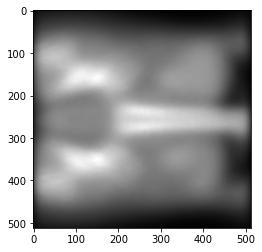

In [287]:
plt.imshow(d, cmap='gray')

In [271]:
df_train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1.1.1',
       'Unnamed: 0.1.1.1.1.1.1.1.1.1',
       ...
       'CrossSection', 'PixelSpacing_Transverse', 'PixelSpacing_Coronal',
       'PixelSpacing_Sagittal', 'PixelSpacing_Transverse_0',
       'PixelSpacing_Transverse_1', 'WidthSpacing', 'DepathSpacing',
       'DepthSpacing', 'CrossSectionSpacing'],
      dtype='object', length=324)

In [282]:
header = '../bucket/Amara/Osteo/Coronal_Slices_detected/'
c = np.zeros((512,512))
print(c.shape)
for i,j in df_train.iterrows():
    CT_acc = df_train.at[i, 'CT_acc']
    slice_number = int(df_train.at[i, 'coronal_slice_detected'])#'L3_slice'])
    image_name = header+str(CT_acc)+'_'+str(slice_number)+'.npy'
    a = np.load(image_name)
    a = a.astype(float)
    a = vol_window(a, 500, 1500)
    a = (a-np.min(a))/(np.max(a)-np.min(a))
    a = 255.0*a
    #print(a.shape)
    image = Image.fromarray(np.uint8(a))
    image = image.resize((512,512))
    
    a = np.array(image)

    c = c+a

    if i%100==0:
        print(i)

(512, 512)
100
200
400
500
700
900
1000
1200
1400
1500
1600
1700
1800
1900
2000
2200
2300
2400
2500
2700
2800
2900
3400
3500
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5300
5400
5500
5600
5700
5900
6000


0.06168767955977297 (512, 512) 3.814697265625e-06 (512, 512, 3)


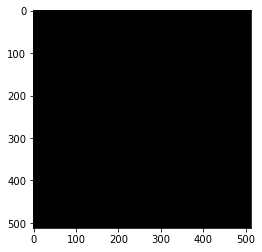

In [243]:
print(a.mean(), a.shape, b.mean(), b.shape)
plt.imshow(b, cmap='gray')